# Locally-Linear Deep Learner on Synthetic Data
Uses attention_model (v3). Additions:  
    - Batch Normalization to the hidden layer after concat.    
    - Similarity batching (to be implemented)  
    - Softmax layer/Activity Regularizer (?) for Concat layer  
Synth data: (10-dimension with cluster-specific noise) 

In [1]:
%env TMPDIR=/tmp/temp 
#For joblib multi-threading

import os, sys
import numpy as np
import time

code_folder=os.path.join(os.getcwd(), "..", "..", "0_code")
sys.path.append(code_folder)

env: TMPDIR=/tmp/temp


In [2]:
import numpy as np
import pandas as pd
df=pd.read_csv("SynthData_10dim_nonoise.csv",
               index_col=0
              )


In [3]:
df.head()

,Type,cluster_labels,Class,feat_000,feat_001,feat_002,feat_003,feat_004,feat_005,feat_006,feat_007,feat_008,feat_009
0,Training,9,1,-1.572929,-0.787550,-0.776094,-1.317869,-1.606713,-0.981606,-1.280226,-1.413003,-1.239058,-1.610741
1,Training,19,1,0.936355,-0.095371,-0.090681,1.197782,1.062599,0.121755,1.201450,1.164756,0.357561,0.921921
2,Training,23,0,1.519406,1.075284,1.085938,0.956381,1.415182,1.291613,0.941112,1.272375,1.359987,1.504084
3,Training,17,1,1.468159,-0.111983,-0.104721,1.801405,1.626605,0.290182,1.820954,1.812075,0.549539,1.401419
4,Training,13,1,-1.126776,-0.250159,-0.254824,-1.173222,-1.211135,-0.465382,-1.153737,-1.193737,-0.652145,-1.119241


In [4]:
df.columns

Index(['Type', 'cluster_labels', 'Class', 'feat_000', 'feat_001', 'feat_002',
       'feat_003', 'feat_004', 'feat_005', 'feat_006', 'feat_007', 'feat_008',
       'feat_009'],
      dtype='object')

In [5]:
X_train=df[df['Type']=="Training"].iloc[:, 3:]
X_test=df[df['Type']=="Testing"].iloc[:,3:]
y_train=df[df['Type']=="Training"].iloc[:,2]
y_test=df[df['Type']=="Testing"].iloc[:,2]

cluster_labels_train=df[df['Type']=='Training']['cluster_labels']
cluster_labels_test=df[df['Type']=='Testing']['cluster_labels']

In [6]:
train_data=X_train.values
train_targets=np.expand_dims(y_train, axis=1).astype(np.float32)
test_data=X_test.values
test_targets=np.expand_dims(y_test, axis=1).astype(np.float32)


## LLDL without Feature weighting

In [7]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
tf.keras.backend.set_floatx('float32')    

from tf_helpers import get_weights_dicts, BinaryCrossEntropyIgnoreNaN
from tf_helpers import SimilarityBatchingDataset

In [8]:
n_feat = train_data.shape[1]
n_attention = 10 #Reduced from 20 to 10. 10 works better
n_attention_hidden=40
n_attention_out=1
n_concat_hidden=128
n_hidden1 =64
n_hidden2 = 64
momentum=0.8
learning_rate=0.001

n_batch=8

label="SynthData_nonoise"

save_folder=os.path.join(time.strftime("%y%m%d_TrainingLocalitySensitivewoFW",
                                       time.localtime()))
checkpoint_path = os.path.join(save_folder, 
                               "LocalitySensitivewoFW_{}".format(label),
                               )

try: 
    os.mkdir(save_folder) 
except OSError as error: 
    print(error) 
    
try:
    os.mkdir(checkpoint_path)
except OSError as error:
    print(error)

from tensorflow.keras.initializers import VarianceScaling
concat_activation="selu"
attention_hidden_activation="selu"
attention_output_activation="sigmoid"
kernel_initializer=VarianceScaling()
hidden_activation="selu"

[WinError 183] Cannot create a file when that file already exists: '210219_TrainingLocalitySensitivewoFW'
[WinError 183] Cannot create a file when that file already exists: '210219_TrainingLocalitySensitivewoFW\\LocalitySensitivewoFW_SynthData_nonoise'


In [9]:
from algorithms import attention_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.losses import BinaryCrossentropy

np.random.seed(0)

input_layer=Input(shape=(n_feat, ))

attentions_layer=attention_model.ConcatAttentions(
    n_attention=n_attention,
    n_attention_hidden=n_attention_hidden,
    n_attention_out=n_attention_out,
    n_feat=n_feat,
    n_hidden=n_concat_hidden,
    activation=concat_activation, 
    kernel_initializer=kernel_initializer,
    kernel_regularizer=l2(1E-5),
    bias_regularizer=l2(1E-5),
    attention_initializer=kernel_initializer,
    attention_hidden_activation=attention_hidden_activation,
    attention_output_activation=attention_output_activation,
    batch_norm_kwargs={"trainable":False, "renorm":False},
)(input_layer)
##Removed dropout for attentions_layer because of Batch normalization
# dropout0=Dropout(0.1)(attentions_layer)
dense_layer1=Dense(n_hidden1, 
                   activation=hidden_activation, 
                   kernel_initializer=kernel_initializer,
                   kernel_regularizer=l2(1E-5),
                   bias_regularizer=l2(1E-5),
                  )(attentions_layer)
# dropout1=Dropout(0.1)(dense_layer1)
dense_layer2=Dense(n_hidden2,
                   activation=hidden_activation,
                   kernel_initializer=kernel_initializer,
                   kernel_regularizer=l2(1E-5),
                   bias_regularizer=l2(1E-5)
                  )(dense_layer1)
# dropout2=Dropout(0.1)(dense_layer2)
output_layer=Dense(1, activation="sigmoid")(dense_layer2)

LSwoFW_model=Model(inputs=input_layer, 
                  outputs=output_layer
                 )

weights_dicts=get_weights_dicts(np.expand_dims(train_targets,1))
loss_fn=BinaryCrossEntropyIgnoreNaN(weights_dicts=weights_dicts)

# loss_fn=tf.nn.sigmoid_cross_entropy_with_logits

LSwoFW_model.compile(loss=loss_fn,
    #loss=BinaryCrossentropy(from_logits=False, 
#                                             reduction=tf.keras.losses.Reduction.AUTO,
#                                            ), 
              optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
              metrics=['accuracy',]
             )

In [10]:
LSwoFW_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
concat_attentions (ConcatAtt (None, 128)               6730      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 19,211
Trainable params: 18,699
Non-trainable params: 512
_________________________________________________________________


In [11]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_accuracy',
                                                 mode='max',
                                                 save_best_only=True,
                                                 save_weights_only=True,
                                                 verbose=1)

csv_filename = os.path.join(checkpoint_path,
                            "training_log.csv"
                            )
csvlogger_callback = tf.keras.callbacks.CSVLogger(filename=csv_filename, append=True)

n_epoch=2000

LSwoFW_model.fit(train_data, 
                train_targets, 
                epochs=n_epoch,
                batch_size=n_batch,
                validation_data=(test_data, test_targets),
                shuffle=True,
                verbose=2, 
                callbacks=[csvlogger_callback,
                           cp_callback
                          ]
               )

Epoch 1/2000
113/113 - 6s - loss: 0.7279 - accuracy: 0.4822 - val_loss: 0.7136 - val_accuracy: 0.4700

Epoch 00001: val_accuracy improved from -inf to 0.47000, saving model to 210219_TrainingLocalitySensitivewoFW\LocalitySensitivewoFW_SynthData_nonoise
Epoch 2/2000
113/113 - 2s - loss: 0.7129 - accuracy: 0.4856 - val_loss: 0.7081 - val_accuracy: 0.5000

Epoch 00002: val_accuracy improved from 0.47000 to 0.50000, saving model to 210219_TrainingLocalitySensitivewoFW\LocalitySensitivewoFW_SynthData_nonoise
Epoch 3/2000
113/113 - 2s - loss: 0.7009 - accuracy: 0.5344 - val_loss: 0.7747 - val_accuracy: 0.4700

Epoch 00003: val_accuracy did not improve from 0.50000
Epoch 4/2000
113/113 - 2s - loss: 0.7014 - accuracy: 0.5100 - val_loss: 0.7005 - val_accuracy: 0.5000

Epoch 00004: val_accuracy did not improve from 0.50000
Epoch 5/2000
113/113 - 2s - loss: 0.7017 - accuracy: 0.5222 - val_loss: 0.7336 - val_accuracy: 0.5300

Epoch 00005: val_accuracy improved from 0.50000 to 0.53000, saving model

113/113 - 3s - loss: 0.6037 - accuracy: 0.6633 - val_loss: 0.6873 - val_accuracy: 0.5700

Epoch 00048: val_accuracy did not improve from 0.66000
Epoch 49/2000
113/113 - 2s - loss: 0.5948 - accuracy: 0.6511 - val_loss: 0.6913 - val_accuracy: 0.6100

Epoch 00049: val_accuracy did not improve from 0.66000
Epoch 50/2000
113/113 - 2s - loss: 0.5881 - accuracy: 0.6700 - val_loss: 0.6963 - val_accuracy: 0.5200

Epoch 00050: val_accuracy did not improve from 0.66000
Epoch 51/2000
113/113 - 2s - loss: 0.5952 - accuracy: 0.6589 - val_loss: 0.6710 - val_accuracy: 0.5900

Epoch 00051: val_accuracy did not improve from 0.66000
Epoch 52/2000
113/113 - 2s - loss: 0.5871 - accuracy: 0.6633 - val_loss: 0.6418 - val_accuracy: 0.6400

Epoch 00052: val_accuracy did not improve from 0.66000
Epoch 53/2000
113/113 - 2s - loss: 0.5852 - accuracy: 0.6611 - val_loss: 0.6757 - val_accuracy: 0.6100

Epoch 00053: val_accuracy did not improve from 0.66000
Epoch 54/2000
113/113 - 2s - loss: 0.5897 - accuracy: 0.6633

113/113 - 2s - loss: 0.5293 - accuracy: 0.7144 - val_loss: 0.6168 - val_accuracy: 0.6700

Epoch 00099: val_accuracy did not improve from 0.67000
Epoch 100/2000
113/113 - 2s - loss: 0.5218 - accuracy: 0.7089 - val_loss: 0.6730 - val_accuracy: 0.6400

Epoch 00100: val_accuracy did not improve from 0.67000
Epoch 101/2000
113/113 - 2s - loss: 0.5369 - accuracy: 0.7089 - val_loss: 0.6244 - val_accuracy: 0.6500

Epoch 00101: val_accuracy did not improve from 0.67000
Epoch 102/2000
113/113 - 2s - loss: 0.5248 - accuracy: 0.6833 - val_loss: 0.6430 - val_accuracy: 0.6600

Epoch 00102: val_accuracy did not improve from 0.67000
Epoch 103/2000
113/113 - 2s - loss: 0.5239 - accuracy: 0.7067 - val_loss: 0.6153 - val_accuracy: 0.6800

Epoch 00103: val_accuracy improved from 0.67000 to 0.68000, saving model to 210219_TrainingLocalitySensitivewoFW\LocalitySensitivewoFW_SynthData_nonoise
Epoch 104/2000
113/113 - 2s - loss: 0.5360 - accuracy: 0.6856 - val_loss: 0.6223 - val_accuracy: 0.7000

Epoch 00104:

113/113 - 3s - loss: 0.4725 - accuracy: 0.7578 - val_loss: 0.6108 - val_accuracy: 0.7000

Epoch 00148: val_accuracy did not improve from 0.74000
Epoch 149/2000
113/113 - 3s - loss: 0.4570 - accuracy: 0.7633 - val_loss: 0.5569 - val_accuracy: 0.7100

Epoch 00149: val_accuracy did not improve from 0.74000
Epoch 150/2000
113/113 - 2s - loss: 0.4526 - accuracy: 0.7489 - val_loss: 0.5918 - val_accuracy: 0.7100

Epoch 00150: val_accuracy did not improve from 0.74000
Epoch 151/2000
113/113 - 2s - loss: 0.4644 - accuracy: 0.7689 - val_loss: 0.5621 - val_accuracy: 0.6900

Epoch 00151: val_accuracy did not improve from 0.74000
Epoch 152/2000
113/113 - 2s - loss: 0.4504 - accuracy: 0.7622 - val_loss: 0.5809 - val_accuracy: 0.6800

Epoch 00152: val_accuracy did not improve from 0.74000
Epoch 153/2000
113/113 - 2s - loss: 0.4531 - accuracy: 0.7489 - val_loss: 0.5736 - val_accuracy: 0.7200

Epoch 00153: val_accuracy did not improve from 0.74000
Epoch 154/2000
113/113 - 2s - loss: 0.4669 - accuracy: 


Epoch 00197: val_accuracy did not improve from 0.77000
Epoch 198/2000
113/113 - 2s - loss: 0.4282 - accuracy: 0.7700 - val_loss: 0.5381 - val_accuracy: 0.7200

Epoch 00198: val_accuracy did not improve from 0.77000
Epoch 199/2000
113/113 - 2s - loss: 0.4167 - accuracy: 0.7811 - val_loss: 0.5317 - val_accuracy: 0.7300

Epoch 00199: val_accuracy did not improve from 0.77000
Epoch 200/2000
113/113 - 2s - loss: 0.4288 - accuracy: 0.7789 - val_loss: 0.5202 - val_accuracy: 0.7500

Epoch 00200: val_accuracy did not improve from 0.77000
Epoch 201/2000
113/113 - 2s - loss: 0.4044 - accuracy: 0.7922 - val_loss: 0.5171 - val_accuracy: 0.7600

Epoch 00201: val_accuracy did not improve from 0.77000
Epoch 202/2000
113/113 - 2s - loss: 0.4106 - accuracy: 0.7878 - val_loss: 0.5427 - val_accuracy: 0.7200

Epoch 00202: val_accuracy did not improve from 0.77000
Epoch 203/2000
113/113 - 2s - loss: 0.4105 - accuracy: 0.7889 - val_loss: 0.5768 - val_accuracy: 0.7000

Epoch 00203: val_accuracy did not impro


Epoch 00247: val_accuracy did not improve from 0.79000
Epoch 248/2000
113/113 - 2s - loss: 0.3914 - accuracy: 0.8144 - val_loss: 0.5205 - val_accuracy: 0.6800

Epoch 00248: val_accuracy did not improve from 0.79000
Epoch 249/2000
113/113 - 3s - loss: 0.3909 - accuracy: 0.8144 - val_loss: 0.5486 - val_accuracy: 0.7500

Epoch 00249: val_accuracy did not improve from 0.79000
Epoch 250/2000
113/113 - 2s - loss: 0.3976 - accuracy: 0.8011 - val_loss: 0.6122 - val_accuracy: 0.7100

Epoch 00250: val_accuracy did not improve from 0.79000
Epoch 251/2000
113/113 - 2s - loss: 0.3916 - accuracy: 0.8122 - val_loss: 0.4780 - val_accuracy: 0.7800

Epoch 00251: val_accuracy did not improve from 0.79000
Epoch 252/2000
113/113 - 2s - loss: 0.3860 - accuracy: 0.7967 - val_loss: 0.5026 - val_accuracy: 0.7400

Epoch 00252: val_accuracy did not improve from 0.79000
Epoch 253/2000
113/113 - 3s - loss: 0.4114 - accuracy: 0.8000 - val_loss: 0.5195 - val_accuracy: 0.7700

Epoch 00253: val_accuracy did not impro


Epoch 00298: val_accuracy did not improve from 0.82000
Epoch 299/2000
113/113 - 3s - loss: 0.3647 - accuracy: 0.8311 - val_loss: 0.5188 - val_accuracy: 0.7000

Epoch 00299: val_accuracy did not improve from 0.82000
Epoch 300/2000
113/113 - 3s - loss: 0.3716 - accuracy: 0.8111 - val_loss: 0.4563 - val_accuracy: 0.7900

Epoch 00300: val_accuracy did not improve from 0.82000
Epoch 301/2000
113/113 - 3s - loss: 0.3623 - accuracy: 0.8222 - val_loss: 0.4347 - val_accuracy: 0.7900

Epoch 00301: val_accuracy did not improve from 0.82000
Epoch 302/2000
113/113 - 3s - loss: 0.3518 - accuracy: 0.8267 - val_loss: 0.5448 - val_accuracy: 0.7400

Epoch 00302: val_accuracy did not improve from 0.82000
Epoch 303/2000
113/113 - 2s - loss: 0.3803 - accuracy: 0.8167 - val_loss: 0.4756 - val_accuracy: 0.7800

Epoch 00303: val_accuracy did not improve from 0.82000
Epoch 304/2000
113/113 - 3s - loss: 0.3879 - accuracy: 0.8144 - val_loss: 0.4338 - val_accuracy: 0.8000

Epoch 00304: val_accuracy did not impro


Epoch 00348: val_accuracy did not improve from 0.84000
Epoch 349/2000
113/113 - 2s - loss: 0.3397 - accuracy: 0.8333 - val_loss: 0.5116 - val_accuracy: 0.7800

Epoch 00349: val_accuracy did not improve from 0.84000
Epoch 350/2000
113/113 - 3s - loss: 0.3676 - accuracy: 0.8322 - val_loss: 0.4680 - val_accuracy: 0.8200

Epoch 00350: val_accuracy did not improve from 0.84000
Epoch 351/2000
113/113 - 3s - loss: 0.3318 - accuracy: 0.8378 - val_loss: 0.4769 - val_accuracy: 0.7800

Epoch 00351: val_accuracy did not improve from 0.84000
Epoch 352/2000
113/113 - 3s - loss: 0.3525 - accuracy: 0.8322 - val_loss: 0.4623 - val_accuracy: 0.8100

Epoch 00352: val_accuracy did not improve from 0.84000
Epoch 353/2000
113/113 - 2s - loss: 0.3270 - accuracy: 0.8367 - val_loss: 0.5087 - val_accuracy: 0.7200

Epoch 00353: val_accuracy did not improve from 0.84000
Epoch 354/2000
113/113 - 2s - loss: 0.3386 - accuracy: 0.8378 - val_loss: 0.4759 - val_accuracy: 0.7800

Epoch 00354: val_accuracy did not impro


Epoch 00399: val_accuracy did not improve from 0.85000
Epoch 400/2000
113/113 - 3s - loss: 0.3050 - accuracy: 0.8567 - val_loss: 0.3971 - val_accuracy: 0.8000

Epoch 00400: val_accuracy did not improve from 0.85000
Epoch 401/2000
113/113 - 3s - loss: 0.3277 - accuracy: 0.8478 - val_loss: 0.4061 - val_accuracy: 0.8200

Epoch 00401: val_accuracy did not improve from 0.85000
Epoch 402/2000
113/113 - 3s - loss: 0.2875 - accuracy: 0.8678 - val_loss: 0.4418 - val_accuracy: 0.7600

Epoch 00402: val_accuracy did not improve from 0.85000
Epoch 403/2000
113/113 - 3s - loss: 0.2945 - accuracy: 0.8733 - val_loss: 0.5110 - val_accuracy: 0.7700

Epoch 00403: val_accuracy did not improve from 0.85000
Epoch 404/2000
113/113 - 3s - loss: 0.2816 - accuracy: 0.8756 - val_loss: 0.3952 - val_accuracy: 0.7700

Epoch 00404: val_accuracy did not improve from 0.85000
Epoch 405/2000
113/113 - 3s - loss: 0.2859 - accuracy: 0.8700 - val_loss: 0.4163 - val_accuracy: 0.8200

Epoch 00405: val_accuracy did not impro


Epoch 00450: val_accuracy did not improve from 0.86000
Epoch 451/2000
113/113 - 3s - loss: 0.2943 - accuracy: 0.8733 - val_loss: 0.3419 - val_accuracy: 0.8500

Epoch 00451: val_accuracy did not improve from 0.86000
Epoch 452/2000
113/113 - 2s - loss: 0.2936 - accuracy: 0.8689 - val_loss: 0.3847 - val_accuracy: 0.8100

Epoch 00452: val_accuracy did not improve from 0.86000
Epoch 453/2000
113/113 - 2s - loss: 0.2494 - accuracy: 0.8911 - val_loss: 0.3000 - val_accuracy: 0.8500

Epoch 00453: val_accuracy did not improve from 0.86000
Epoch 454/2000
113/113 - 2s - loss: 0.2988 - accuracy: 0.8667 - val_loss: 0.4534 - val_accuracy: 0.8200

Epoch 00454: val_accuracy did not improve from 0.86000
Epoch 455/2000
113/113 - 2s - loss: 0.3222 - accuracy: 0.8533 - val_loss: 0.4798 - val_accuracy: 0.7700

Epoch 00455: val_accuracy did not improve from 0.86000
Epoch 456/2000
113/113 - 2s - loss: 0.2465 - accuracy: 0.8889 - val_loss: 0.3739 - val_accuracy: 0.8000

Epoch 00456: val_accuracy did not impro

113/113 - 2s - loss: 0.2254 - accuracy: 0.9056 - val_loss: 0.3636 - val_accuracy: 0.8200

Epoch 00500: val_accuracy did not improve from 0.91000
Epoch 501/2000
113/113 - 2s - loss: 0.2519 - accuracy: 0.9000 - val_loss: 0.3070 - val_accuracy: 0.8500

Epoch 00501: val_accuracy did not improve from 0.91000
Epoch 502/2000
113/113 - 2s - loss: 0.2474 - accuracy: 0.9044 - val_loss: 0.3460 - val_accuracy: 0.8600

Epoch 00502: val_accuracy did not improve from 0.91000
Epoch 503/2000
113/113 - 2s - loss: 0.2265 - accuracy: 0.9067 - val_loss: 0.2834 - val_accuracy: 0.8800

Epoch 00503: val_accuracy did not improve from 0.91000
Epoch 504/2000
113/113 - 2s - loss: 0.2532 - accuracy: 0.8911 - val_loss: 0.3100 - val_accuracy: 0.8600

Epoch 00504: val_accuracy did not improve from 0.91000
Epoch 505/2000
113/113 - 2s - loss: 0.2214 - accuracy: 0.9111 - val_loss: 0.4992 - val_accuracy: 0.7500

Epoch 00505: val_accuracy did not improve from 0.91000
Epoch 506/2000
113/113 - 3s - loss: 0.2784 - accuracy: 


Epoch 00551: val_accuracy did not improve from 0.91000
Epoch 552/2000
113/113 - 2s - loss: 0.2114 - accuracy: 0.9200 - val_loss: 0.4245 - val_accuracy: 0.8400

Epoch 00552: val_accuracy did not improve from 0.91000
Epoch 553/2000
113/113 - 2s - loss: 0.2309 - accuracy: 0.9022 - val_loss: 0.3899 - val_accuracy: 0.8300

Epoch 00553: val_accuracy did not improve from 0.91000
Epoch 554/2000
113/113 - 2s - loss: 0.2056 - accuracy: 0.9156 - val_loss: 0.3591 - val_accuracy: 0.8500

Epoch 00554: val_accuracy did not improve from 0.91000
Epoch 555/2000
113/113 - 2s - loss: 0.2390 - accuracy: 0.8956 - val_loss: 0.4206 - val_accuracy: 0.8300

Epoch 00555: val_accuracy did not improve from 0.91000
Epoch 556/2000
113/113 - 2s - loss: 0.2420 - accuracy: 0.9022 - val_loss: 0.4216 - val_accuracy: 0.8300

Epoch 00556: val_accuracy did not improve from 0.91000
Epoch 557/2000
113/113 - 2s - loss: 0.2023 - accuracy: 0.9178 - val_loss: 0.3836 - val_accuracy: 0.8100

Epoch 00557: val_accuracy did not impro

113/113 - 4s - loss: 0.2278 - accuracy: 0.9111 - val_loss: 0.3907 - val_accuracy: 0.8300

Epoch 00603: val_accuracy did not improve from 0.91000
Epoch 604/2000
113/113 - 4s - loss: 0.2618 - accuracy: 0.9011 - val_loss: 0.4117 - val_accuracy: 0.8700

Epoch 00604: val_accuracy did not improve from 0.91000
Epoch 605/2000
113/113 - 4s - loss: 0.2002 - accuracy: 0.9144 - val_loss: 0.4259 - val_accuracy: 0.8000

Epoch 00605: val_accuracy did not improve from 0.91000
Epoch 606/2000
113/113 - 4s - loss: 0.1965 - accuracy: 0.9178 - val_loss: 0.3219 - val_accuracy: 0.8500

Epoch 00606: val_accuracy did not improve from 0.91000
Epoch 607/2000
113/113 - 4s - loss: 0.1889 - accuracy: 0.9267 - val_loss: 0.3209 - val_accuracy: 0.8500

Epoch 00607: val_accuracy did not improve from 0.91000
Epoch 608/2000
113/113 - 4s - loss: 0.1893 - accuracy: 0.9300 - val_loss: 0.2903 - val_accuracy: 0.8600

Epoch 00608: val_accuracy did not improve from 0.91000
Epoch 609/2000
113/113 - 4s - loss: 0.2253 - accuracy: 


Epoch 00654: val_accuracy did not improve from 0.91000
Epoch 655/2000
113/113 - 4s - loss: 0.1639 - accuracy: 0.9322 - val_loss: 0.2580 - val_accuracy: 0.8900

Epoch 00655: val_accuracy did not improve from 0.91000
Epoch 656/2000
113/113 - 4s - loss: 0.1590 - accuracy: 0.9400 - val_loss: 0.2540 - val_accuracy: 0.9100

Epoch 00656: val_accuracy did not improve from 0.91000
Epoch 657/2000
113/113 - 4s - loss: 0.2044 - accuracy: 0.9211 - val_loss: 0.2764 - val_accuracy: 0.8400

Epoch 00657: val_accuracy did not improve from 0.91000
Epoch 658/2000
113/113 - 4s - loss: 0.2052 - accuracy: 0.9200 - val_loss: 0.2740 - val_accuracy: 0.8700

Epoch 00658: val_accuracy did not improve from 0.91000
Epoch 659/2000
113/113 - 4s - loss: 0.1916 - accuracy: 0.9278 - val_loss: 0.3583 - val_accuracy: 0.8900

Epoch 00659: val_accuracy did not improve from 0.91000
Epoch 660/2000
113/113 - 4s - loss: 0.1825 - accuracy: 0.9356 - val_loss: 0.2660 - val_accuracy: 0.8800

Epoch 00660: val_accuracy did not impro


Epoch 00705: val_accuracy did not improve from 0.92000
Epoch 706/2000
113/113 - 4s - loss: 0.1634 - accuracy: 0.9411 - val_loss: 0.3483 - val_accuracy: 0.8400

Epoch 00706: val_accuracy did not improve from 0.92000
Epoch 707/2000
113/113 - 4s - loss: 0.1662 - accuracy: 0.9367 - val_loss: 0.3692 - val_accuracy: 0.8300

Epoch 00707: val_accuracy did not improve from 0.92000
Epoch 708/2000
113/113 - 4s - loss: 0.1700 - accuracy: 0.9344 - val_loss: 0.3544 - val_accuracy: 0.8500

Epoch 00708: val_accuracy did not improve from 0.92000
Epoch 709/2000
113/113 - 4s - loss: 0.1623 - accuracy: 0.9400 - val_loss: 0.2915 - val_accuracy: 0.8800

Epoch 00709: val_accuracy did not improve from 0.92000
Epoch 710/2000
113/113 - 4s - loss: 0.1476 - accuracy: 0.9478 - val_loss: 0.2127 - val_accuracy: 0.8900

Epoch 00710: val_accuracy did not improve from 0.92000
Epoch 711/2000
113/113 - 4s - loss: 0.1763 - accuracy: 0.9244 - val_loss: 0.3485 - val_accuracy: 0.8700

Epoch 00711: val_accuracy did not impro

113/113 - 4s - loss: 0.1676 - accuracy: 0.9389 - val_loss: 0.3157 - val_accuracy: 0.9000

Epoch 00757: val_accuracy did not improve from 0.92000
Epoch 758/2000
113/113 - 4s - loss: 0.1725 - accuracy: 0.9222 - val_loss: 0.2653 - val_accuracy: 0.8900

Epoch 00758: val_accuracy did not improve from 0.92000
Epoch 759/2000
113/113 - 4s - loss: 0.2309 - accuracy: 0.9178 - val_loss: 0.3431 - val_accuracy: 0.8400

Epoch 00759: val_accuracy did not improve from 0.92000
Epoch 760/2000
113/113 - 4s - loss: 0.1598 - accuracy: 0.9378 - val_loss: 0.3057 - val_accuracy: 0.8900

Epoch 00760: val_accuracy did not improve from 0.92000
Epoch 761/2000
113/113 - 4s - loss: 0.1531 - accuracy: 0.9522 - val_loss: 0.2472 - val_accuracy: 0.9000

Epoch 00761: val_accuracy did not improve from 0.92000
Epoch 762/2000
113/113 - 4s - loss: 0.1558 - accuracy: 0.9389 - val_loss: 0.2869 - val_accuracy: 0.8900

Epoch 00762: val_accuracy did not improve from 0.92000
Epoch 763/2000
113/113 - 4s - loss: 0.1627 - accuracy: 

113/113 - 4s - loss: 0.1268 - accuracy: 0.9522 - val_loss: 0.2835 - val_accuracy: 0.9100

Epoch 00807: val_accuracy did not improve from 0.95000
Epoch 808/2000
113/113 - 4s - loss: 0.1422 - accuracy: 0.9444 - val_loss: 0.3244 - val_accuracy: 0.8800

Epoch 00808: val_accuracy did not improve from 0.95000
Epoch 809/2000
113/113 - 4s - loss: 0.1480 - accuracy: 0.9467 - val_loss: 0.4786 - val_accuracy: 0.8100

Epoch 00809: val_accuracy did not improve from 0.95000
Epoch 810/2000
113/113 - 4s - loss: 0.1958 - accuracy: 0.9267 - val_loss: 0.3461 - val_accuracy: 0.8900

Epoch 00810: val_accuracy did not improve from 0.95000
Epoch 811/2000
113/113 - 4s - loss: 0.1551 - accuracy: 0.9344 - val_loss: 0.2938 - val_accuracy: 0.8700

Epoch 00811: val_accuracy did not improve from 0.95000
Epoch 812/2000
113/113 - 4s - loss: 0.1698 - accuracy: 0.9444 - val_loss: 0.3953 - val_accuracy: 0.8800

Epoch 00812: val_accuracy did not improve from 0.95000
Epoch 813/2000
113/113 - 4s - loss: 0.2103 - accuracy: 


Epoch 00858: val_accuracy did not improve from 0.95000
Epoch 859/2000
113/113 - 4s - loss: 0.1978 - accuracy: 0.9189 - val_loss: 0.3998 - val_accuracy: 0.8400

Epoch 00859: val_accuracy did not improve from 0.95000
Epoch 860/2000
113/113 - 4s - loss: 0.1651 - accuracy: 0.9400 - val_loss: 0.3652 - val_accuracy: 0.8800

Epoch 00860: val_accuracy did not improve from 0.95000
Epoch 861/2000
113/113 - 4s - loss: 0.1625 - accuracy: 0.9389 - val_loss: 0.4378 - val_accuracy: 0.8900

Epoch 00861: val_accuracy did not improve from 0.95000
Epoch 862/2000
113/113 - 4s - loss: 0.1635 - accuracy: 0.9367 - val_loss: 0.3645 - val_accuracy: 0.8500

Epoch 00862: val_accuracy did not improve from 0.95000
Epoch 863/2000
113/113 - 4s - loss: 0.1648 - accuracy: 0.9433 - val_loss: 0.2866 - val_accuracy: 0.9200

Epoch 00863: val_accuracy did not improve from 0.95000
Epoch 864/2000
113/113 - 4s - loss: 0.1399 - accuracy: 0.9489 - val_loss: 0.2812 - val_accuracy: 0.8900

Epoch 00864: val_accuracy did not impro

113/113 - 4s - loss: 0.1258 - accuracy: 0.9600 - val_loss: 0.3388 - val_accuracy: 0.8600

Epoch 00910: val_accuracy did not improve from 0.95000
Epoch 911/2000
113/113 - 4s - loss: 0.1631 - accuracy: 0.9444 - val_loss: 0.3415 - val_accuracy: 0.8400

Epoch 00911: val_accuracy did not improve from 0.95000
Epoch 912/2000
113/113 - 4s - loss: 0.1274 - accuracy: 0.9467 - val_loss: 0.3022 - val_accuracy: 0.9000

Epoch 00912: val_accuracy did not improve from 0.95000
Epoch 913/2000
113/113 - 4s - loss: 0.1313 - accuracy: 0.9522 - val_loss: 0.2066 - val_accuracy: 0.9300

Epoch 00913: val_accuracy did not improve from 0.95000
Epoch 914/2000
113/113 - 4s - loss: 0.1668 - accuracy: 0.9422 - val_loss: 0.4271 - val_accuracy: 0.8700

Epoch 00914: val_accuracy did not improve from 0.95000
Epoch 915/2000
113/113 - 4s - loss: 0.1979 - accuracy: 0.9311 - val_loss: 0.4348 - val_accuracy: 0.8800

Epoch 00915: val_accuracy did not improve from 0.95000
Epoch 916/2000
113/113 - 4s - loss: 0.1768 - accuracy: 


Epoch 00961: val_accuracy did not improve from 0.95000
Epoch 962/2000
113/113 - 4s - loss: 0.1599 - accuracy: 0.9400 - val_loss: 0.3259 - val_accuracy: 0.9000

Epoch 00962: val_accuracy did not improve from 0.95000
Epoch 963/2000
113/113 - 4s - loss: 0.1213 - accuracy: 0.9556 - val_loss: 0.3069 - val_accuracy: 0.8900

Epoch 00963: val_accuracy did not improve from 0.95000
Epoch 964/2000
113/113 - 4s - loss: 0.1376 - accuracy: 0.9533 - val_loss: 0.2500 - val_accuracy: 0.9100

Epoch 00964: val_accuracy did not improve from 0.95000
Epoch 965/2000
113/113 - 4s - loss: 0.1277 - accuracy: 0.9578 - val_loss: 0.2777 - val_accuracy: 0.9200

Epoch 00965: val_accuracy did not improve from 0.95000
Epoch 966/2000
113/113 - 4s - loss: 0.1318 - accuracy: 0.9533 - val_loss: 0.2957 - val_accuracy: 0.9100

Epoch 00966: val_accuracy did not improve from 0.95000
Epoch 967/2000
113/113 - 4s - loss: 0.1191 - accuracy: 0.9578 - val_loss: 0.4001 - val_accuracy: 0.8400

Epoch 00967: val_accuracy did not impro

113/113 - 4s - loss: 0.1723 - accuracy: 0.9422 - val_loss: 0.3644 - val_accuracy: 0.8700

Epoch 01013: val_accuracy did not improve from 0.95000
Epoch 1014/2000
113/113 - 4s - loss: 0.1393 - accuracy: 0.9500 - val_loss: 0.2454 - val_accuracy: 0.9000

Epoch 01014: val_accuracy did not improve from 0.95000
Epoch 1015/2000
113/113 - 4s - loss: 0.1398 - accuracy: 0.9489 - val_loss: 0.3147 - val_accuracy: 0.9000

Epoch 01015: val_accuracy did not improve from 0.95000
Epoch 1016/2000
113/113 - 4s - loss: 0.1484 - accuracy: 0.9456 - val_loss: 0.3063 - val_accuracy: 0.9100

Epoch 01016: val_accuracy did not improve from 0.95000
Epoch 1017/2000
113/113 - 4s - loss: 0.1177 - accuracy: 0.9622 - val_loss: 0.2412 - val_accuracy: 0.8900

Epoch 01017: val_accuracy did not improve from 0.95000
Epoch 1018/2000
113/113 - 4s - loss: 0.1158 - accuracy: 0.9589 - val_loss: 0.3463 - val_accuracy: 0.8600

Epoch 01018: val_accuracy did not improve from 0.95000
Epoch 1019/2000
113/113 - 4s - loss: 0.1257 - accu

113/113 - 4s - loss: 0.1408 - accuracy: 0.9456 - val_loss: 0.2627 - val_accuracy: 0.9100

Epoch 01064: val_accuracy did not improve from 0.95000
Epoch 1065/2000
113/113 - 4s - loss: 0.1148 - accuracy: 0.9644 - val_loss: 0.2876 - val_accuracy: 0.8800

Epoch 01065: val_accuracy did not improve from 0.95000
Epoch 1066/2000
113/113 - 4s - loss: 0.1035 - accuracy: 0.9744 - val_loss: 0.2572 - val_accuracy: 0.9100

Epoch 01066: val_accuracy did not improve from 0.95000
Epoch 1067/2000
113/113 - 4s - loss: 0.1436 - accuracy: 0.9489 - val_loss: 0.2426 - val_accuracy: 0.9000

Epoch 01067: val_accuracy did not improve from 0.95000
Epoch 1068/2000
113/113 - 4s - loss: 0.1313 - accuracy: 0.9533 - val_loss: 0.4221 - val_accuracy: 0.8200

Epoch 01068: val_accuracy did not improve from 0.95000
Epoch 1069/2000
113/113 - 4s - loss: 0.1796 - accuracy: 0.9400 - val_loss: 0.3104 - val_accuracy: 0.8700

Epoch 01069: val_accuracy did not improve from 0.95000
Epoch 1070/2000
113/113 - 4s - loss: 0.1447 - accu

113/113 - 4s - loss: 0.1205 - accuracy: 0.9511 - val_loss: 0.3797 - val_accuracy: 0.8900

Epoch 01115: val_accuracy did not improve from 0.95000
Epoch 1116/2000
113/113 - 4s - loss: 0.1691 - accuracy: 0.9356 - val_loss: 0.2162 - val_accuracy: 0.9200

Epoch 01116: val_accuracy did not improve from 0.95000
Epoch 1117/2000
113/113 - 4s - loss: 0.1013 - accuracy: 0.9589 - val_loss: 0.2863 - val_accuracy: 0.8800

Epoch 01117: val_accuracy did not improve from 0.95000
Epoch 1118/2000
113/113 - 4s - loss: 0.1100 - accuracy: 0.9544 - val_loss: 0.2056 - val_accuracy: 0.9300

Epoch 01118: val_accuracy did not improve from 0.95000
Epoch 1119/2000
113/113 - 4s - loss: 0.1207 - accuracy: 0.9533 - val_loss: 0.3438 - val_accuracy: 0.9100

Epoch 01119: val_accuracy did not improve from 0.95000
Epoch 1120/2000
113/113 - 4s - loss: 0.1715 - accuracy: 0.9356 - val_loss: 0.2362 - val_accuracy: 0.8900

Epoch 01120: val_accuracy did not improve from 0.95000
Epoch 1121/2000
113/113 - 4s - loss: 0.1391 - accu

113/113 - 4s - loss: 0.1492 - accuracy: 0.9400 - val_loss: 0.4990 - val_accuracy: 0.8500

Epoch 01166: val_accuracy did not improve from 0.95000
Epoch 1167/2000
113/113 - 4s - loss: 0.1823 - accuracy: 0.9433 - val_loss: 0.2812 - val_accuracy: 0.8600

Epoch 01167: val_accuracy did not improve from 0.95000
Epoch 1168/2000
113/113 - 4s - loss: 0.1866 - accuracy: 0.9422 - val_loss: 0.2585 - val_accuracy: 0.9000

Epoch 01168: val_accuracy did not improve from 0.95000
Epoch 1169/2000
113/113 - 4s - loss: 0.1446 - accuracy: 0.9500 - val_loss: 0.3690 - val_accuracy: 0.8700

Epoch 01169: val_accuracy did not improve from 0.95000
Epoch 1170/2000
113/113 - 4s - loss: 0.1336 - accuracy: 0.9500 - val_loss: 0.2749 - val_accuracy: 0.8600

Epoch 01170: val_accuracy did not improve from 0.95000
Epoch 1171/2000
113/113 - 4s - loss: 0.1024 - accuracy: 0.9589 - val_loss: 0.3604 - val_accuracy: 0.8800

Epoch 01171: val_accuracy did not improve from 0.95000
Epoch 1172/2000
113/113 - 4s - loss: 0.0915 - accu

113/113 - 4s - loss: 0.1042 - accuracy: 0.9611 - val_loss: 0.2137 - val_accuracy: 0.9400

Epoch 01217: val_accuracy did not improve from 0.95000
Epoch 1218/2000
113/113 - 4s - loss: 0.1152 - accuracy: 0.9622 - val_loss: 0.4023 - val_accuracy: 0.9000

Epoch 01218: val_accuracy did not improve from 0.95000
Epoch 1219/2000
113/113 - 4s - loss: 0.1836 - accuracy: 0.9389 - val_loss: 0.5932 - val_accuracy: 0.8400

Epoch 01219: val_accuracy did not improve from 0.95000
Epoch 1220/2000
113/113 - 4s - loss: 0.1394 - accuracy: 0.9511 - val_loss: 0.3621 - val_accuracy: 0.8800

Epoch 01220: val_accuracy did not improve from 0.95000
Epoch 1221/2000
113/113 - 4s - loss: 0.1038 - accuracy: 0.9678 - val_loss: 0.2542 - val_accuracy: 0.9200

Epoch 01221: val_accuracy did not improve from 0.95000
Epoch 1222/2000
113/113 - 4s - loss: 0.1418 - accuracy: 0.9533 - val_loss: 0.4184 - val_accuracy: 0.8700

Epoch 01222: val_accuracy did not improve from 0.95000
Epoch 1223/2000
113/113 - 4s - loss: 0.1680 - accu


Epoch 01267: val_accuracy did not improve from 0.96000
Epoch 1268/2000
113/113 - 4s - loss: 0.1309 - accuracy: 0.9567 - val_loss: 0.2831 - val_accuracy: 0.8600

Epoch 01268: val_accuracy did not improve from 0.96000
Epoch 1269/2000
113/113 - 4s - loss: 0.1035 - accuracy: 0.9567 - val_loss: 0.3163 - val_accuracy: 0.8700

Epoch 01269: val_accuracy did not improve from 0.96000
Epoch 1270/2000
113/113 - 4s - loss: 0.1045 - accuracy: 0.9633 - val_loss: 0.2026 - val_accuracy: 0.9200

Epoch 01270: val_accuracy did not improve from 0.96000
Epoch 1271/2000
113/113 - 4s - loss: 0.1032 - accuracy: 0.9633 - val_loss: 0.2563 - val_accuracy: 0.8900

Epoch 01271: val_accuracy did not improve from 0.96000
Epoch 1272/2000
113/113 - 4s - loss: 0.0982 - accuracy: 0.9700 - val_loss: 0.2872 - val_accuracy: 0.9000

Epoch 01272: val_accuracy did not improve from 0.96000
Epoch 1273/2000
113/113 - 4s - loss: 0.1172 - accuracy: 0.9611 - val_loss: 0.3430 - val_accuracy: 0.8700

Epoch 01273: val_accuracy did not


Epoch 01318: val_accuracy did not improve from 0.96000
Epoch 1319/2000
113/113 - 4s - loss: 0.1070 - accuracy: 0.9667 - val_loss: 0.1743 - val_accuracy: 0.9400

Epoch 01319: val_accuracy did not improve from 0.96000
Epoch 1320/2000
113/113 - 4s - loss: 0.1215 - accuracy: 0.9544 - val_loss: 0.3292 - val_accuracy: 0.9000

Epoch 01320: val_accuracy did not improve from 0.96000
Epoch 1321/2000
113/113 - 4s - loss: 0.1960 - accuracy: 0.9433 - val_loss: 0.4241 - val_accuracy: 0.8500

Epoch 01321: val_accuracy did not improve from 0.96000
Epoch 1322/2000
113/113 - 4s - loss: 0.1423 - accuracy: 0.9500 - val_loss: 0.2515 - val_accuracy: 0.9100

Epoch 01322: val_accuracy did not improve from 0.96000
Epoch 1323/2000
113/113 - 4s - loss: 0.1050 - accuracy: 0.9622 - val_loss: 0.2499 - val_accuracy: 0.8700

Epoch 01323: val_accuracy did not improve from 0.96000
Epoch 1324/2000
113/113 - 4s - loss: 0.1246 - accuracy: 0.9533 - val_loss: 0.2243 - val_accuracy: 0.9100

Epoch 01324: val_accuracy did not


Epoch 01369: val_accuracy did not improve from 0.96000
Epoch 1370/2000
113/113 - 4s - loss: 0.1260 - accuracy: 0.9544 - val_loss: 0.2389 - val_accuracy: 0.9200

Epoch 01370: val_accuracy did not improve from 0.96000
Epoch 1371/2000
113/113 - 4s - loss: 0.1032 - accuracy: 0.9511 - val_loss: 0.2188 - val_accuracy: 0.9200

Epoch 01371: val_accuracy did not improve from 0.96000
Epoch 1372/2000
113/113 - 4s - loss: 0.1056 - accuracy: 0.9622 - val_loss: 0.2199 - val_accuracy: 0.9100

Epoch 01372: val_accuracy did not improve from 0.96000
Epoch 1373/2000
113/113 - 4s - loss: 0.1102 - accuracy: 0.9622 - val_loss: 0.2627 - val_accuracy: 0.9200

Epoch 01373: val_accuracy did not improve from 0.96000
Epoch 1374/2000
113/113 - 4s - loss: 0.1411 - accuracy: 0.9456 - val_loss: 0.3402 - val_accuracy: 0.8800

Epoch 01374: val_accuracy did not improve from 0.96000
Epoch 1375/2000
113/113 - 4s - loss: 0.1434 - accuracy: 0.9478 - val_loss: 0.2965 - val_accuracy: 0.9000

Epoch 01375: val_accuracy did not


Epoch 01420: val_accuracy did not improve from 0.96000
Epoch 1421/2000
113/113 - 4s - loss: 0.0835 - accuracy: 0.9733 - val_loss: 0.2451 - val_accuracy: 0.9100

Epoch 01421: val_accuracy did not improve from 0.96000
Epoch 1422/2000
113/113 - 4s - loss: 0.0869 - accuracy: 0.9667 - val_loss: 0.2356 - val_accuracy: 0.9300

Epoch 01422: val_accuracy did not improve from 0.96000
Epoch 1423/2000
113/113 - 4s - loss: 0.1001 - accuracy: 0.9656 - val_loss: 0.2718 - val_accuracy: 0.9000

Epoch 01423: val_accuracy did not improve from 0.96000
Epoch 1424/2000
113/113 - 4s - loss: 0.1028 - accuracy: 0.9689 - val_loss: 0.2182 - val_accuracy: 0.9300

Epoch 01424: val_accuracy did not improve from 0.96000
Epoch 1425/2000
113/113 - 4s - loss: 0.1035 - accuracy: 0.9644 - val_loss: 0.3763 - val_accuracy: 0.8700

Epoch 01425: val_accuracy did not improve from 0.96000
Epoch 1426/2000
113/113 - 4s - loss: 0.1932 - accuracy: 0.9344 - val_loss: 0.2907 - val_accuracy: 0.9200

Epoch 01426: val_accuracy did not

113/113 - 4s - loss: 0.1216 - accuracy: 0.9644 - val_loss: 0.2808 - val_accuracy: 0.9100

Epoch 01471: val_accuracy did not improve from 0.97000
Epoch 1472/2000
113/113 - 3s - loss: 0.1056 - accuracy: 0.9656 - val_loss: 0.1884 - val_accuracy: 0.9300

Epoch 01472: val_accuracy did not improve from 0.97000
Epoch 1473/2000
113/113 - 4s - loss: 0.0988 - accuracy: 0.9678 - val_loss: 0.2044 - val_accuracy: 0.9400

Epoch 01473: val_accuracy did not improve from 0.97000
Epoch 1474/2000
113/113 - 4s - loss: 0.1060 - accuracy: 0.9622 - val_loss: 0.2489 - val_accuracy: 0.9300

Epoch 01474: val_accuracy did not improve from 0.97000
Epoch 1475/2000
113/113 - 3s - loss: 0.1011 - accuracy: 0.9633 - val_loss: 0.2164 - val_accuracy: 0.9200

Epoch 01475: val_accuracy did not improve from 0.97000
Epoch 1476/2000
113/113 - 4s - loss: 0.0955 - accuracy: 0.9633 - val_loss: 0.2789 - val_accuracy: 0.8900

Epoch 01476: val_accuracy did not improve from 0.97000
Epoch 1477/2000
113/113 - 4s - loss: 0.1078 - accu

113/113 - 3s - loss: 0.1011 - accuracy: 0.9667 - val_loss: 0.2423 - val_accuracy: 0.9200

Epoch 01522: val_accuracy did not improve from 0.97000
Epoch 1523/2000
113/113 - 3s - loss: 0.0879 - accuracy: 0.9689 - val_loss: 0.2765 - val_accuracy: 0.9300

Epoch 01523: val_accuracy did not improve from 0.97000
Epoch 1524/2000
113/113 - 3s - loss: 0.0752 - accuracy: 0.9733 - val_loss: 0.2690 - val_accuracy: 0.9100

Epoch 01524: val_accuracy did not improve from 0.97000
Epoch 1525/2000
113/113 - 4s - loss: 0.0786 - accuracy: 0.9744 - val_loss: 0.2281 - val_accuracy: 0.9100

Epoch 01525: val_accuracy did not improve from 0.97000
Epoch 1526/2000
113/113 - 3s - loss: 0.0958 - accuracy: 0.9756 - val_loss: 0.3040 - val_accuracy: 0.8800

Epoch 01526: val_accuracy did not improve from 0.97000
Epoch 1527/2000
113/113 - 4s - loss: 0.1074 - accuracy: 0.9667 - val_loss: 0.2208 - val_accuracy: 0.9300

Epoch 01527: val_accuracy did not improve from 0.97000
Epoch 1528/2000
113/113 - 4s - loss: 0.0900 - accu

113/113 - 3s - loss: 0.1354 - accuracy: 0.9589 - val_loss: 0.2661 - val_accuracy: 0.9200

Epoch 01573: val_accuracy did not improve from 0.97000
Epoch 1574/2000
113/113 - 3s - loss: 0.1323 - accuracy: 0.9511 - val_loss: 0.2921 - val_accuracy: 0.8700

Epoch 01574: val_accuracy did not improve from 0.97000
Epoch 1575/2000
113/113 - 3s - loss: 0.0763 - accuracy: 0.9778 - val_loss: 0.2701 - val_accuracy: 0.9100

Epoch 01575: val_accuracy did not improve from 0.97000
Epoch 1576/2000
113/113 - 3s - loss: 0.1020 - accuracy: 0.9678 - val_loss: 0.2477 - val_accuracy: 0.9200

Epoch 01576: val_accuracy did not improve from 0.97000
Epoch 1577/2000
113/113 - 3s - loss: 0.0898 - accuracy: 0.9744 - val_loss: 0.2082 - val_accuracy: 0.9300

Epoch 01577: val_accuracy did not improve from 0.97000
Epoch 1578/2000
113/113 - 3s - loss: 0.0950 - accuracy: 0.9744 - val_loss: 0.1810 - val_accuracy: 0.9400

Epoch 01578: val_accuracy did not improve from 0.97000
Epoch 1579/2000
113/113 - 4s - loss: 0.0900 - accu

113/113 - 4s - loss: 0.1192 - accuracy: 0.9533 - val_loss: 0.3445 - val_accuracy: 0.9000

Epoch 01624: val_accuracy did not improve from 0.97000
Epoch 1625/2000
113/113 - 4s - loss: 0.1002 - accuracy: 0.9700 - val_loss: 0.2699 - val_accuracy: 0.9000

Epoch 01625: val_accuracy did not improve from 0.97000
Epoch 1626/2000
113/113 - 3s - loss: 0.0939 - accuracy: 0.9644 - val_loss: 0.2391 - val_accuracy: 0.9100

Epoch 01626: val_accuracy did not improve from 0.97000
Epoch 1627/2000
113/113 - 4s - loss: 0.1232 - accuracy: 0.9567 - val_loss: 0.3437 - val_accuracy: 0.9100

Epoch 01627: val_accuracy did not improve from 0.97000
Epoch 1628/2000
113/113 - 4s - loss: 0.1340 - accuracy: 0.9522 - val_loss: 0.2730 - val_accuracy: 0.9100

Epoch 01628: val_accuracy did not improve from 0.97000
Epoch 1629/2000
113/113 - 4s - loss: 0.1124 - accuracy: 0.9556 - val_loss: 0.2462 - val_accuracy: 0.9400

Epoch 01629: val_accuracy did not improve from 0.97000
Epoch 1630/2000
113/113 - 4s - loss: 0.1075 - accu

113/113 - 4s - loss: 0.1110 - accuracy: 0.9656 - val_loss: 0.1597 - val_accuracy: 0.9500

Epoch 01675: val_accuracy did not improve from 0.97000
Epoch 1676/2000
113/113 - 4s - loss: 0.1140 - accuracy: 0.9711 - val_loss: 0.2708 - val_accuracy: 0.9000

Epoch 01676: val_accuracy did not improve from 0.97000
Epoch 1677/2000
113/113 - 3s - loss: 0.1650 - accuracy: 0.9500 - val_loss: 0.1890 - val_accuracy: 0.9600

Epoch 01677: val_accuracy did not improve from 0.97000
Epoch 1678/2000
113/113 - 4s - loss: 0.0788 - accuracy: 0.9789 - val_loss: 0.2115 - val_accuracy: 0.9100

Epoch 01678: val_accuracy did not improve from 0.97000
Epoch 1679/2000
113/113 - 4s - loss: 0.0861 - accuracy: 0.9756 - val_loss: 0.1993 - val_accuracy: 0.9300

Epoch 01679: val_accuracy did not improve from 0.97000
Epoch 1680/2000
113/113 - 3s - loss: 0.1116 - accuracy: 0.9633 - val_loss: 0.2788 - val_accuracy: 0.9100

Epoch 01680: val_accuracy did not improve from 0.97000
Epoch 1681/2000
113/113 - 3s - loss: 0.1170 - accu

113/113 - 4s - loss: 0.1339 - accuracy: 0.9511 - val_loss: 0.2665 - val_accuracy: 0.8800

Epoch 01726: val_accuracy did not improve from 0.97000
Epoch 1727/2000
113/113 - 4s - loss: 0.0913 - accuracy: 0.9700 - val_loss: 0.1780 - val_accuracy: 0.9300

Epoch 01727: val_accuracy did not improve from 0.97000
Epoch 1728/2000
113/113 - 4s - loss: 0.0764 - accuracy: 0.9733 - val_loss: 0.2203 - val_accuracy: 0.9200

Epoch 01728: val_accuracy did not improve from 0.97000
Epoch 1729/2000
113/113 - 4s - loss: 0.0802 - accuracy: 0.9756 - val_loss: 0.2217 - val_accuracy: 0.9300

Epoch 01729: val_accuracy did not improve from 0.97000
Epoch 1730/2000
113/113 - 4s - loss: 0.0743 - accuracy: 0.9778 - val_loss: 0.1848 - val_accuracy: 0.9400

Epoch 01730: val_accuracy did not improve from 0.97000
Epoch 1731/2000
113/113 - 4s - loss: 0.1070 - accuracy: 0.9600 - val_loss: 0.4027 - val_accuracy: 0.9100

Epoch 01731: val_accuracy did not improve from 0.97000
Epoch 1732/2000
113/113 - 4s - loss: 0.1581 - accu

113/113 - 4s - loss: 0.0845 - accuracy: 0.9767 - val_loss: 0.2831 - val_accuracy: 0.9200

Epoch 01777: val_accuracy did not improve from 0.97000
Epoch 1778/2000
113/113 - 4s - loss: 0.0961 - accuracy: 0.9744 - val_loss: 0.4230 - val_accuracy: 0.8900

Epoch 01778: val_accuracy did not improve from 0.97000
Epoch 1779/2000
113/113 - 3s - loss: 0.1392 - accuracy: 0.9556 - val_loss: 0.2188 - val_accuracy: 0.9200

Epoch 01779: val_accuracy did not improve from 0.97000
Epoch 1780/2000
113/113 - 4s - loss: 0.0998 - accuracy: 0.9711 - val_loss: 0.2746 - val_accuracy: 0.9000

Epoch 01780: val_accuracy did not improve from 0.97000
Epoch 1781/2000
113/113 - 4s - loss: 0.0756 - accuracy: 0.9767 - val_loss: 0.2426 - val_accuracy: 0.9300

Epoch 01781: val_accuracy did not improve from 0.97000
Epoch 1782/2000
113/113 - 4s - loss: 0.0767 - accuracy: 0.9800 - val_loss: 0.2065 - val_accuracy: 0.9100

Epoch 01782: val_accuracy did not improve from 0.97000
Epoch 1783/2000
113/113 - 3s - loss: 0.1299 - accu


Epoch 01827: val_accuracy did not improve from 0.98000
Epoch 1828/2000
113/113 - 3s - loss: 0.1329 - accuracy: 0.9511 - val_loss: 0.3785 - val_accuracy: 0.8800

Epoch 01828: val_accuracy did not improve from 0.98000
Epoch 1829/2000
113/113 - 4s - loss: 0.0974 - accuracy: 0.9744 - val_loss: 0.1997 - val_accuracy: 0.9100

Epoch 01829: val_accuracy did not improve from 0.98000
Epoch 1830/2000
113/113 - 4s - loss: 0.1278 - accuracy: 0.9567 - val_loss: 0.2707 - val_accuracy: 0.9000

Epoch 01830: val_accuracy did not improve from 0.98000
Epoch 1831/2000
113/113 - 4s - loss: 0.1034 - accuracy: 0.9656 - val_loss: 0.1591 - val_accuracy: 0.9400

Epoch 01831: val_accuracy did not improve from 0.98000
Epoch 1832/2000
113/113 - 4s - loss: 0.0921 - accuracy: 0.9678 - val_loss: 0.2838 - val_accuracy: 0.9000

Epoch 01832: val_accuracy did not improve from 0.98000
Epoch 1833/2000
113/113 - 4s - loss: 0.1354 - accuracy: 0.9611 - val_loss: 0.5777 - val_accuracy: 0.9000

Epoch 01833: val_accuracy did not


Epoch 01878: val_accuracy did not improve from 0.98000
Epoch 1879/2000
113/113 - 4s - loss: 0.2155 - accuracy: 0.9322 - val_loss: 0.3711 - val_accuracy: 0.8700

Epoch 01879: val_accuracy did not improve from 0.98000
Epoch 1880/2000
113/113 - 3s - loss: 0.1806 - accuracy: 0.9400 - val_loss: 0.2655 - val_accuracy: 0.9100

Epoch 01880: val_accuracy did not improve from 0.98000
Epoch 1881/2000
113/113 - 4s - loss: 0.1332 - accuracy: 0.9489 - val_loss: 0.2017 - val_accuracy: 0.9500

Epoch 01881: val_accuracy did not improve from 0.98000
Epoch 1882/2000
113/113 - 4s - loss: 0.0930 - accuracy: 0.9700 - val_loss: 0.1797 - val_accuracy: 0.9600

Epoch 01882: val_accuracy did not improve from 0.98000
Epoch 1883/2000
113/113 - 4s - loss: 0.0671 - accuracy: 0.9844 - val_loss: 0.1681 - val_accuracy: 0.9400

Epoch 01883: val_accuracy did not improve from 0.98000
Epoch 1884/2000
113/113 - 4s - loss: 0.0632 - accuracy: 0.9833 - val_loss: 0.1827 - val_accuracy: 0.9300

Epoch 01884: val_accuracy did not


Epoch 01929: val_accuracy did not improve from 0.98000
Epoch 1930/2000
113/113 - 4s - loss: 0.0671 - accuracy: 0.9822 - val_loss: 0.1317 - val_accuracy: 0.9500

Epoch 01930: val_accuracy did not improve from 0.98000
Epoch 1931/2000
113/113 - 4s - loss: 0.0716 - accuracy: 0.9767 - val_loss: 0.2198 - val_accuracy: 0.9200

Epoch 01931: val_accuracy did not improve from 0.98000
Epoch 1932/2000
113/113 - 4s - loss: 0.0666 - accuracy: 0.9878 - val_loss: 0.1972 - val_accuracy: 0.9400

Epoch 01932: val_accuracy did not improve from 0.98000
Epoch 1933/2000
113/113 - 4s - loss: 0.0847 - accuracy: 0.9711 - val_loss: 0.2842 - val_accuracy: 0.9000

Epoch 01933: val_accuracy did not improve from 0.98000
Epoch 1934/2000
113/113 - 3s - loss: 0.0770 - accuracy: 0.9778 - val_loss: 0.2084 - val_accuracy: 0.9200

Epoch 01934: val_accuracy did not improve from 0.98000
Epoch 1935/2000
113/113 - 4s - loss: 0.0729 - accuracy: 0.9767 - val_loss: 0.1558 - val_accuracy: 0.9400

Epoch 01935: val_accuracy did not


Epoch 01980: val_accuracy did not improve from 0.98000
Epoch 1981/2000
113/113 - 4s - loss: 0.0859 - accuracy: 0.9744 - val_loss: 0.2427 - val_accuracy: 0.9000

Epoch 01981: val_accuracy did not improve from 0.98000
Epoch 1982/2000
113/113 - 4s - loss: 0.1063 - accuracy: 0.9678 - val_loss: 0.1846 - val_accuracy: 0.9200

Epoch 01982: val_accuracy did not improve from 0.98000
Epoch 1983/2000
113/113 - 4s - loss: 0.1575 - accuracy: 0.9511 - val_loss: 0.2436 - val_accuracy: 0.9300

Epoch 01983: val_accuracy did not improve from 0.98000
Epoch 1984/2000
113/113 - 4s - loss: 0.1176 - accuracy: 0.9611 - val_loss: 0.2742 - val_accuracy: 0.9100

Epoch 01984: val_accuracy did not improve from 0.98000
Epoch 1985/2000
113/113 - 3s - loss: 0.1091 - accuracy: 0.9700 - val_loss: 0.2573 - val_accuracy: 0.9300

Epoch 01985: val_accuracy did not improve from 0.98000
Epoch 1986/2000
113/113 - 4s - loss: 0.0814 - accuracy: 0.9744 - val_loss: 0.2230 - val_accuracy: 0.9100

Epoch 01986: val_accuracy did not

In [ ]:
# LSwoFW_model.load_weights(os.path.join("210210_TrainingLocalitySensitivewoFW",
#                                       "LocalitySensitivewoFW_label" ))

In [ ]:
# attentions=[LSwoFW_model.layers[1].attention_layers[i](train_data).numpy() for i in range(10)]
# attentions=np.reshape(attentions, (900,10))

In [12]:
attentions=LSwoFW_model.layers[1](train_data).numpy()

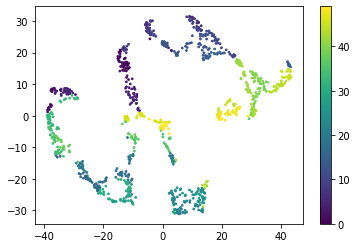

In [13]:
from sklearn.manifold import TSNE
dr=TSNE()
embed_attentions=dr.fit_transform(attentions)

%matplotlib inline
import matplotlib.pyplot as plt

fig,ax=plt.subplots()

scatter=ax.scatter(embed_attentions[:,0], embed_attentions[:,1],
                   c=cluster_labels_train,
                   s=3
                  )

plt.colorbar(scatter)

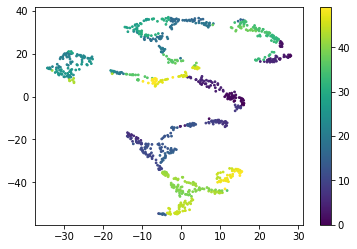

In [14]:
from umap import UMAP
mapper=UMAP()
embed_attentions=dr.fit_transform(attentions)

fig,ax=plt.subplots()

scatter=ax.scatter(embed_attentions[:,0], embed_attentions[:,1],
                   c=cluster_labels_train,
                   s=3
                  )

plt.colorbar(scatter)

## Dense model

In [15]:
n_feat = train_data.shape[1]
n_attention = 10 #Reduced from 20 to 10. 10 works better
n_attention_hidden=40
n_attention_out=1
n_concat_hidden=128
n_hidden1 =64
n_hidden2 = 64
momentum=0.8
learning_rate=0.001

n_batch=8

label="SynthData"

save_folder=os.path.join(time.strftime("%y%m%d_TrainingDense",
                                       time.localtime()))
checkpoint_path = os.path.join(save_folder, 
                               "Dense_{}".format(label),
                               )

try: 
    os.mkdir(save_folder) 
except OSError as error: 
    print(error) 
    
try:
    os.mkdir(checkpoint_path)
except OSError as error:
    print(error)

from tensorflow.keras.initializers import VarianceScaling
concat_activation="selu"
attention_hidden_activation="selu"
attention_output_activation="sigmoid"
kernel_initializer=VarianceScaling()
hidden_activation="selu"

In [16]:
from algorithms import attention_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.losses import BinaryCrossentropy

np.random.seed(0)

input_layer=Input(shape=(n_feat, ))

dense_layer0=Dense(n_attention_hidden*n_attention,
                   activation="sigmoid", 
                   kernel_initializer=kernel_initializer,
                   kernel_regularizer=l2(1E-5),
                   bias_regularizer=l2(1E-5),
                  )(input_layer)
# attentions_layer=attention_model.ConcatAttentions(
#     n_attention=n_attention,
#     n_attention_hidden=n_attention_hidden,
#     n_attention_out=n_attention_out,
#     n_feat=n_feat,
#     n_hidden=n_concat_hidden,
#     activation=concat_activation, 
#     kernel_initializer=kernel_initializer,
#     kernel_regularizer=l2(1E-5),
#     bias_regularizer=l2(1E-5),
#     attention_initializer=kernel_initializer,
#     attention_hidden_activation=attention_hidden_activation,
#     attention_output_activation=attention_output_activation,
#     batch_norm_kwargs={"trainable":False, "renorm":False},
# )(input_layer)
##Removed dropout for attentions_layer because of Batch normalization
# dropout0=Dropout(0.1)(attentions_layer)
dense_layer1=Dense(n_hidden1, 
                   activation=hidden_activation, 
                   kernel_initializer=kernel_initializer,
                   kernel_regularizer=l2(1E-5),
                   bias_regularizer=l2(1E-5),
                  )(dense_layer0)
# dropout1=Dropout(0.1)(dense_layer1)
dense_layer2=Dense(n_hidden2,
                   activation=hidden_activation,
                   kernel_initializer=kernel_initializer,
                   kernel_regularizer=l2(1E-5),
                   bias_regularizer=l2(1E-5)
                  )(dense_layer1)
# dropout2=Dropout(0.1)(dense_layer2)
output_layer=Dense(1, activation="sigmoid")(dense_layer2)

dense_model=Model(inputs=input_layer, 
                  outputs=output_layer
                 )

weights_dicts=get_weights_dicts(np.expand_dims(train_targets,1))
loss_fn=BinaryCrossEntropyIgnoreNaN(weights_dicts=weights_dicts)

# loss_fn=tf.nn.sigmoid_cross_entropy_with_logits

dense_model.compile(loss=loss_fn,
    #loss=BinaryCrossentropy(from_logits=False, 
#                                             reduction=tf.keras.losses.Reduction.AUTO,
#                                            ), 
              optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
              metrics=['accuracy',]
             )

In [17]:
dense_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense_4 (Dense)              (None, 400)               4400      
_________________________________________________________________
dense_5 (Dense)              (None, 64)                25664     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 34,289
Trainable params: 34,289
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_accuracy',
                                                 mode='max',
                                                 save_best_only=True,
                                                 save_weights_only=True,
                                                 verbose=1)

csv_filename = os.path.join(checkpoint_path,
                            "training_log.csv"
                            )
csvlogger_callback = tf.keras.callbacks.CSVLogger(filename=csv_filename, append=True)

n_epoch=2000


dense_model.fit(train_data, 
                train_targets, 
                epochs=n_epoch,
                batch_size=n_batch,
                validation_data=(test_data, test_targets),
                shuffle=True,
                verbose=2, 
                callbacks=[csvlogger_callback,
                           cp_callback
                          ]
               )

Epoch 1/2000
113/113 - 2s - loss: 0.7460 - accuracy: 0.5144 - val_loss: 0.7321 - val_accuracy: 0.5300

Epoch 00001: val_accuracy improved from -inf to 0.53000, saving model to 210219_TrainingDense\Dense_SynthData
Epoch 2/2000
113/113 - 1s - loss: 0.7272 - accuracy: 0.4811 - val_loss: 0.7172 - val_accuracy: 0.4700

Epoch 00002: val_accuracy did not improve from 0.53000
Epoch 3/2000
113/113 - 1s - loss: 0.7171 - accuracy: 0.5100 - val_loss: 0.7245 - val_accuracy: 0.4700

Epoch 00003: val_accuracy did not improve from 0.53000
Epoch 4/2000
113/113 - 1s - loss: 0.7240 - accuracy: 0.5111 - val_loss: 0.7100 - val_accuracy: 0.4200

Epoch 00004: val_accuracy did not improve from 0.53000
Epoch 5/2000
113/113 - 1s - loss: 0.7174 - accuracy: 0.4767 - val_loss: 0.6968 - val_accuracy: 0.5500

Epoch 00005: val_accuracy improved from 0.53000 to 0.55000, saving model to 210219_TrainingDense\Dense_SynthData
Epoch 6/2000
113/113 - 1s - loss: 0.7279 - accuracy: 0.5244 - val_loss: 0.7103 - val_accuracy: 0.

113/113 - 1s - loss: 0.6682 - accuracy: 0.6078 - val_loss: 0.6875 - val_accuracy: 0.6000

Epoch 00051: val_accuracy did not improve from 0.61000
Epoch 52/2000
113/113 - 1s - loss: 0.6519 - accuracy: 0.6189 - val_loss: 0.6954 - val_accuracy: 0.6200

Epoch 00052: val_accuracy improved from 0.61000 to 0.62000, saving model to 210219_TrainingDense\Dense_SynthData
Epoch 53/2000
113/113 - 1s - loss: 0.6533 - accuracy: 0.6100 - val_loss: 0.7070 - val_accuracy: 0.5300

Epoch 00053: val_accuracy did not improve from 0.62000
Epoch 54/2000
113/113 - 1s - loss: 0.6716 - accuracy: 0.6022 - val_loss: 0.7123 - val_accuracy: 0.5600

Epoch 00054: val_accuracy did not improve from 0.62000
Epoch 55/2000
113/113 - 1s - loss: 0.6474 - accuracy: 0.6300 - val_loss: 0.7031 - val_accuracy: 0.5500

Epoch 00055: val_accuracy did not improve from 0.62000
Epoch 56/2000
113/113 - 1s - loss: 0.6540 - accuracy: 0.6133 - val_loss: 0.6877 - val_accuracy: 0.5900

Epoch 00056: val_accuracy did not improve from 0.62000
Ep

113/113 - 1s - loss: 0.6155 - accuracy: 0.6400 - val_loss: 0.6609 - val_accuracy: 0.5800

Epoch 00102: val_accuracy did not improve from 0.65000
Epoch 103/2000
113/113 - 1s - loss: 0.6047 - accuracy: 0.6444 - val_loss: 0.6728 - val_accuracy: 0.6000

Epoch 00103: val_accuracy did not improve from 0.65000
Epoch 104/2000
113/113 - 1s - loss: 0.6094 - accuracy: 0.6456 - val_loss: 0.6465 - val_accuracy: 0.6000

Epoch 00104: val_accuracy did not improve from 0.65000
Epoch 105/2000
113/113 - 1s - loss: 0.6155 - accuracy: 0.6433 - val_loss: 0.6470 - val_accuracy: 0.5700

Epoch 00105: val_accuracy did not improve from 0.65000
Epoch 106/2000
113/113 - 1s - loss: 0.6095 - accuracy: 0.6433 - val_loss: 0.6441 - val_accuracy: 0.6100

Epoch 00106: val_accuracy did not improve from 0.65000
Epoch 107/2000
113/113 - 1s - loss: 0.5983 - accuracy: 0.6444 - val_loss: 0.6802 - val_accuracy: 0.6000

Epoch 00107: val_accuracy did not improve from 0.65000
Epoch 108/2000
113/113 - 1s - loss: 0.6036 - accuracy: 


Epoch 00152: val_accuracy did not improve from 0.67000
Epoch 153/2000
113/113 - 1s - loss: 0.5710 - accuracy: 0.6978 - val_loss: 0.6677 - val_accuracy: 0.6100

Epoch 00153: val_accuracy did not improve from 0.67000
Epoch 154/2000
113/113 - 1s - loss: 0.5564 - accuracy: 0.6944 - val_loss: 0.6370 - val_accuracy: 0.6100

Epoch 00154: val_accuracy did not improve from 0.67000
Epoch 155/2000
113/113 - 1s - loss: 0.5624 - accuracy: 0.7011 - val_loss: 0.6618 - val_accuracy: 0.6300

Epoch 00155: val_accuracy did not improve from 0.67000
Epoch 156/2000
113/113 - 1s - loss: 0.5578 - accuracy: 0.6989 - val_loss: 0.6735 - val_accuracy: 0.6200

Epoch 00156: val_accuracy did not improve from 0.67000
Epoch 157/2000
113/113 - 1s - loss: 0.5557 - accuracy: 0.7022 - val_loss: 0.6399 - val_accuracy: 0.5900

Epoch 00157: val_accuracy did not improve from 0.67000
Epoch 158/2000
113/113 - 1s - loss: 0.5507 - accuracy: 0.7067 - val_loss: 0.6443 - val_accuracy: 0.6100

Epoch 00158: val_accuracy did not impro


Epoch 00203: val_accuracy did not improve from 0.69000
Epoch 204/2000
113/113 - 1s - loss: 0.5071 - accuracy: 0.7489 - val_loss: 0.5966 - val_accuracy: 0.6400

Epoch 00204: val_accuracy did not improve from 0.69000
Epoch 205/2000
113/113 - 1s - loss: 0.4983 - accuracy: 0.7422 - val_loss: 0.6698 - val_accuracy: 0.6200

Epoch 00205: val_accuracy did not improve from 0.69000
Epoch 206/2000
113/113 - 1s - loss: 0.5012 - accuracy: 0.7356 - val_loss: 0.6496 - val_accuracy: 0.6200

Epoch 00206: val_accuracy did not improve from 0.69000
Epoch 207/2000
113/113 - 1s - loss: 0.5090 - accuracy: 0.7200 - val_loss: 0.6123 - val_accuracy: 0.6400

Epoch 00207: val_accuracy did not improve from 0.69000
Epoch 208/2000
113/113 - 1s - loss: 0.5034 - accuracy: 0.7333 - val_loss: 0.6436 - val_accuracy: 0.6100

Epoch 00208: val_accuracy did not improve from 0.69000
Epoch 209/2000
113/113 - 1s - loss: 0.4973 - accuracy: 0.7322 - val_loss: 0.6341 - val_accuracy: 0.6100

Epoch 00209: val_accuracy did not impro


Epoch 00254: val_accuracy did not improve from 0.73000
Epoch 255/2000
113/113 - 1s - loss: 0.4621 - accuracy: 0.7578 - val_loss: 0.6284 - val_accuracy: 0.6600

Epoch 00255: val_accuracy did not improve from 0.73000
Epoch 256/2000
113/113 - 1s - loss: 0.4528 - accuracy: 0.7722 - val_loss: 0.5792 - val_accuracy: 0.6700

Epoch 00256: val_accuracy did not improve from 0.73000
Epoch 257/2000
113/113 - 1s - loss: 0.4411 - accuracy: 0.7844 - val_loss: 0.6812 - val_accuracy: 0.6500

Epoch 00257: val_accuracy did not improve from 0.73000
Epoch 258/2000
113/113 - 1s - loss: 0.4659 - accuracy: 0.7544 - val_loss: 0.5793 - val_accuracy: 0.7100

Epoch 00258: val_accuracy did not improve from 0.73000
Epoch 259/2000
113/113 - 1s - loss: 0.4463 - accuracy: 0.7844 - val_loss: 0.5848 - val_accuracy: 0.6800

Epoch 00259: val_accuracy did not improve from 0.73000
Epoch 260/2000
113/113 - 1s - loss: 0.4617 - accuracy: 0.7744 - val_loss: 0.6121 - val_accuracy: 0.6500

Epoch 00260: val_accuracy did not impro


Epoch 00305: val_accuracy did not improve from 0.76000
Epoch 306/2000
113/113 - 1s - loss: 0.4414 - accuracy: 0.7778 - val_loss: 0.5498 - val_accuracy: 0.6900

Epoch 00306: val_accuracy did not improve from 0.76000
Epoch 307/2000
113/113 - 1s - loss: 0.4235 - accuracy: 0.7967 - val_loss: 0.5500 - val_accuracy: 0.7200

Epoch 00307: val_accuracy did not improve from 0.76000
Epoch 308/2000
113/113 - 1s - loss: 0.4265 - accuracy: 0.7989 - val_loss: 0.6267 - val_accuracy: 0.6600

Epoch 00308: val_accuracy did not improve from 0.76000
Epoch 309/2000
113/113 - 1s - loss: 0.4240 - accuracy: 0.7922 - val_loss: 0.5877 - val_accuracy: 0.6800

Epoch 00309: val_accuracy did not improve from 0.76000
Epoch 310/2000
113/113 - 1s - loss: 0.4410 - accuracy: 0.7800 - val_loss: 0.5709 - val_accuracy: 0.6900

Epoch 00310: val_accuracy did not improve from 0.76000
Epoch 311/2000
113/113 - 1s - loss: 0.4260 - accuracy: 0.7756 - val_loss: 0.6189 - val_accuracy: 0.6700

Epoch 00311: val_accuracy did not impro

113/113 - 1s - loss: 0.4095 - accuracy: 0.8089 - val_loss: 0.5542 - val_accuracy: 0.7100

Epoch 00357: val_accuracy did not improve from 0.76000
Epoch 358/2000
113/113 - 1s - loss: 0.4220 - accuracy: 0.7900 - val_loss: 0.5545 - val_accuracy: 0.7400

Epoch 00358: val_accuracy did not improve from 0.76000
Epoch 359/2000
113/113 - 1s - loss: 0.3956 - accuracy: 0.8022 - val_loss: 0.7551 - val_accuracy: 0.6500

Epoch 00359: val_accuracy did not improve from 0.76000
Epoch 360/2000
113/113 - 1s - loss: 0.4207 - accuracy: 0.7967 - val_loss: 0.5548 - val_accuracy: 0.7300

Epoch 00360: val_accuracy did not improve from 0.76000
Epoch 361/2000
113/113 - 1s - loss: 0.4104 - accuracy: 0.8011 - val_loss: 0.5109 - val_accuracy: 0.7100

Epoch 00361: val_accuracy did not improve from 0.76000
Epoch 362/2000
113/113 - 1s - loss: 0.4169 - accuracy: 0.7967 - val_loss: 0.5311 - val_accuracy: 0.7200

Epoch 00362: val_accuracy did not improve from 0.76000
Epoch 363/2000
113/113 - 1s - loss: 0.4100 - accuracy: 


Epoch 00407: val_accuracy did not improve from 0.78000
Epoch 408/2000
113/113 - 1s - loss: 0.3930 - accuracy: 0.8133 - val_loss: 0.5214 - val_accuracy: 0.7700

Epoch 00408: val_accuracy did not improve from 0.78000
Epoch 409/2000
113/113 - 1s - loss: 0.3888 - accuracy: 0.8189 - val_loss: 0.5238 - val_accuracy: 0.7500

Epoch 00409: val_accuracy did not improve from 0.78000
Epoch 410/2000
113/113 - 1s - loss: 0.3759 - accuracy: 0.8289 - val_loss: 0.5051 - val_accuracy: 0.7400

Epoch 00410: val_accuracy did not improve from 0.78000
Epoch 411/2000
113/113 - 1s - loss: 0.3756 - accuracy: 0.8322 - val_loss: 0.5078 - val_accuracy: 0.7300

Epoch 00411: val_accuracy did not improve from 0.78000
Epoch 412/2000
113/113 - 1s - loss: 0.3886 - accuracy: 0.8078 - val_loss: 0.6014 - val_accuracy: 0.6800

Epoch 00412: val_accuracy did not improve from 0.78000
Epoch 413/2000
113/113 - 1s - loss: 0.4073 - accuracy: 0.8011 - val_loss: 0.4628 - val_accuracy: 0.7600

Epoch 00413: val_accuracy did not impro


Epoch 00458: val_accuracy did not improve from 0.80000
Epoch 459/2000
113/113 - 1s - loss: 0.3629 - accuracy: 0.8422 - val_loss: 0.5511 - val_accuracy: 0.7700

Epoch 00459: val_accuracy did not improve from 0.80000
Epoch 460/2000
113/113 - 1s - loss: 0.3785 - accuracy: 0.8256 - val_loss: 0.5271 - val_accuracy: 0.7100

Epoch 00460: val_accuracy did not improve from 0.80000
Epoch 461/2000
113/113 - 1s - loss: 0.3782 - accuracy: 0.8278 - val_loss: 0.5151 - val_accuracy: 0.7600

Epoch 00461: val_accuracy did not improve from 0.80000
Epoch 462/2000
113/113 - 1s - loss: 0.3618 - accuracy: 0.8322 - val_loss: 0.4779 - val_accuracy: 0.7500

Epoch 00462: val_accuracy did not improve from 0.80000
Epoch 463/2000
113/113 - 1s - loss: 0.3690 - accuracy: 0.8311 - val_loss: 0.4573 - val_accuracy: 0.7500

Epoch 00463: val_accuracy did not improve from 0.80000
Epoch 464/2000
113/113 - 1s - loss: 0.3618 - accuracy: 0.8300 - val_loss: 0.4837 - val_accuracy: 0.7600

Epoch 00464: val_accuracy did not impro


Epoch 00509: val_accuracy did not improve from 0.81000
Epoch 510/2000
113/113 - 1s - loss: 0.3333 - accuracy: 0.8522 - val_loss: 0.5265 - val_accuracy: 0.7400

Epoch 00510: val_accuracy did not improve from 0.81000
Epoch 511/2000
113/113 - 1s - loss: 0.3768 - accuracy: 0.8378 - val_loss: 0.5165 - val_accuracy: 0.7800

Epoch 00511: val_accuracy did not improve from 0.81000
Epoch 512/2000
113/113 - 1s - loss: 0.3659 - accuracy: 0.8289 - val_loss: 0.4809 - val_accuracy: 0.7900

Epoch 00512: val_accuracy did not improve from 0.81000
Epoch 513/2000
113/113 - 1s - loss: 0.3659 - accuracy: 0.8422 - val_loss: 0.4788 - val_accuracy: 0.7700

Epoch 00513: val_accuracy did not improve from 0.81000
Epoch 514/2000
113/113 - 1s - loss: 0.3528 - accuracy: 0.8333 - val_loss: 0.4665 - val_accuracy: 0.7700

Epoch 00514: val_accuracy did not improve from 0.81000
Epoch 515/2000
113/113 - 1s - loss: 0.3402 - accuracy: 0.8467 - val_loss: 0.4562 - val_accuracy: 0.8000

Epoch 00515: val_accuracy did not impro


Epoch 00560: val_accuracy did not improve from 0.82000
Epoch 561/2000
113/113 - 1s - loss: 0.3397 - accuracy: 0.8478 - val_loss: 0.4482 - val_accuracy: 0.7900

Epoch 00561: val_accuracy did not improve from 0.82000
Epoch 562/2000
113/113 - 1s - loss: 0.3316 - accuracy: 0.8567 - val_loss: 0.4513 - val_accuracy: 0.8000

Epoch 00562: val_accuracy did not improve from 0.82000
Epoch 563/2000
113/113 - 1s - loss: 0.3646 - accuracy: 0.8344 - val_loss: 0.4713 - val_accuracy: 0.7900

Epoch 00563: val_accuracy did not improve from 0.82000
Epoch 564/2000
113/113 - 1s - loss: 0.3284 - accuracy: 0.8644 - val_loss: 0.4503 - val_accuracy: 0.7800

Epoch 00564: val_accuracy did not improve from 0.82000
Epoch 565/2000
113/113 - 1s - loss: 0.3469 - accuracy: 0.8478 - val_loss: 0.4486 - val_accuracy: 0.8000

Epoch 00565: val_accuracy did not improve from 0.82000
Epoch 566/2000
113/113 - 1s - loss: 0.3317 - accuracy: 0.8567 - val_loss: 0.4616 - val_accuracy: 0.7900

Epoch 00566: val_accuracy did not impro


Epoch 00611: val_accuracy did not improve from 0.84000
Epoch 612/2000
113/113 - 1s - loss: 0.3270 - accuracy: 0.8567 - val_loss: 0.4722 - val_accuracy: 0.8000

Epoch 00612: val_accuracy did not improve from 0.84000
Epoch 613/2000
113/113 - 1s - loss: 0.3198 - accuracy: 0.8611 - val_loss: 0.4736 - val_accuracy: 0.8000

Epoch 00613: val_accuracy did not improve from 0.84000
Epoch 614/2000
113/113 - 1s - loss: 0.3320 - accuracy: 0.8567 - val_loss: 0.4228 - val_accuracy: 0.8400

Epoch 00614: val_accuracy did not improve from 0.84000
Epoch 615/2000
113/113 - 1s - loss: 0.3272 - accuracy: 0.8578 - val_loss: 0.4862 - val_accuracy: 0.8000

Epoch 00615: val_accuracy did not improve from 0.84000
Epoch 616/2000
113/113 - 1s - loss: 0.3227 - accuracy: 0.8544 - val_loss: 0.4559 - val_accuracy: 0.8100

Epoch 00616: val_accuracy did not improve from 0.84000
Epoch 617/2000
113/113 - 1s - loss: 0.3151 - accuracy: 0.8678 - val_loss: 0.4559 - val_accuracy: 0.8000

Epoch 00617: val_accuracy did not impro


Epoch 00662: val_accuracy did not improve from 0.86000
Epoch 663/2000
113/113 - 1s - loss: 0.3289 - accuracy: 0.8589 - val_loss: 0.3918 - val_accuracy: 0.8100

Epoch 00663: val_accuracy did not improve from 0.86000
Epoch 664/2000
113/113 - 1s - loss: 0.3226 - accuracy: 0.8589 - val_loss: 0.4833 - val_accuracy: 0.7900

Epoch 00664: val_accuracy did not improve from 0.86000
Epoch 665/2000
113/113 - 1s - loss: 0.2994 - accuracy: 0.8733 - val_loss: 0.4163 - val_accuracy: 0.8000

Epoch 00665: val_accuracy did not improve from 0.86000
Epoch 666/2000
113/113 - 1s - loss: 0.3100 - accuracy: 0.8811 - val_loss: 0.4868 - val_accuracy: 0.8000

Epoch 00666: val_accuracy did not improve from 0.86000
Epoch 667/2000
113/113 - 1s - loss: 0.3098 - accuracy: 0.8756 - val_loss: 0.4133 - val_accuracy: 0.8000

Epoch 00667: val_accuracy did not improve from 0.86000
Epoch 668/2000
113/113 - 1s - loss: 0.3059 - accuracy: 0.8744 - val_loss: 0.4280 - val_accuracy: 0.7900

Epoch 00668: val_accuracy did not impro


Epoch 00713: val_accuracy did not improve from 0.87000
Epoch 714/2000
113/113 - 1s - loss: 0.3030 - accuracy: 0.8889 - val_loss: 0.4883 - val_accuracy: 0.7900

Epoch 00714: val_accuracy did not improve from 0.87000
Epoch 715/2000
113/113 - 1s - loss: 0.2976 - accuracy: 0.8822 - val_loss: 0.4537 - val_accuracy: 0.7900

Epoch 00715: val_accuracy did not improve from 0.87000
Epoch 716/2000
113/113 - 1s - loss: 0.3000 - accuracy: 0.8778 - val_loss: 0.4542 - val_accuracy: 0.8100

Epoch 00716: val_accuracy did not improve from 0.87000
Epoch 717/2000
113/113 - 1s - loss: 0.3127 - accuracy: 0.8678 - val_loss: 0.3894 - val_accuracy: 0.8300

Epoch 00717: val_accuracy did not improve from 0.87000
Epoch 718/2000
113/113 - 1s - loss: 0.3175 - accuracy: 0.8711 - val_loss: 0.3851 - val_accuracy: 0.8600

Epoch 00718: val_accuracy did not improve from 0.87000
Epoch 719/2000
113/113 - 1s - loss: 0.2862 - accuracy: 0.8844 - val_loss: 0.5079 - val_accuracy: 0.7800

Epoch 00719: val_accuracy did not impro


Epoch 00764: val_accuracy did not improve from 0.88000
Epoch 765/2000
113/113 - 1s - loss: 0.2969 - accuracy: 0.8822 - val_loss: 0.4625 - val_accuracy: 0.8000

Epoch 00765: val_accuracy did not improve from 0.88000
Epoch 766/2000
113/113 - 1s - loss: 0.3485 - accuracy: 0.8556 - val_loss: 0.4574 - val_accuracy: 0.8000

Epoch 00766: val_accuracy did not improve from 0.88000
Epoch 767/2000
113/113 - 1s - loss: 0.2945 - accuracy: 0.8778 - val_loss: 0.4758 - val_accuracy: 0.8500

Epoch 00767: val_accuracy did not improve from 0.88000
Epoch 768/2000
113/113 - 1s - loss: 0.3094 - accuracy: 0.8722 - val_loss: 0.4179 - val_accuracy: 0.8100

Epoch 00768: val_accuracy did not improve from 0.88000
Epoch 769/2000
113/113 - 1s - loss: 0.2800 - accuracy: 0.8900 - val_loss: 0.5187 - val_accuracy: 0.7900

Epoch 00769: val_accuracy did not improve from 0.88000
Epoch 770/2000
113/113 - 1s - loss: 0.3123 - accuracy: 0.8656 - val_loss: 0.3740 - val_accuracy: 0.8600

Epoch 00770: val_accuracy did not impro


Epoch 00815: val_accuracy did not improve from 0.89000
Epoch 816/2000
113/113 - 1s - loss: 0.2595 - accuracy: 0.9044 - val_loss: 0.3853 - val_accuracy: 0.8500

Epoch 00816: val_accuracy did not improve from 0.89000
Epoch 817/2000
113/113 - 1s - loss: 0.3178 - accuracy: 0.8678 - val_loss: 0.5779 - val_accuracy: 0.7500

Epoch 00817: val_accuracy did not improve from 0.89000
Epoch 818/2000
113/113 - 1s - loss: 0.2894 - accuracy: 0.8889 - val_loss: 0.3593 - val_accuracy: 0.8500

Epoch 00818: val_accuracy did not improve from 0.89000
Epoch 819/2000
113/113 - 1s - loss: 0.2865 - accuracy: 0.8878 - val_loss: 0.5072 - val_accuracy: 0.8400

Epoch 00819: val_accuracy did not improve from 0.89000
Epoch 820/2000
113/113 - 1s - loss: 0.2987 - accuracy: 0.8800 - val_loss: 0.3261 - val_accuracy: 0.8600

Epoch 00820: val_accuracy did not improve from 0.89000
Epoch 821/2000
113/113 - 1s - loss: 0.3137 - accuracy: 0.8667 - val_loss: 0.3983 - val_accuracy: 0.7900

Epoch 00821: val_accuracy did not impro


Epoch 00866: val_accuracy did not improve from 0.90000
Epoch 867/2000
113/113 - 1s - loss: 0.2671 - accuracy: 0.8889 - val_loss: 0.3591 - val_accuracy: 0.8700

Epoch 00867: val_accuracy did not improve from 0.90000
Epoch 868/2000
113/113 - 1s - loss: 0.2833 - accuracy: 0.9056 - val_loss: 0.4055 - val_accuracy: 0.8200

Epoch 00868: val_accuracy did not improve from 0.90000
Epoch 869/2000
113/113 - 1s - loss: 0.2671 - accuracy: 0.9056 - val_loss: 0.4289 - val_accuracy: 0.8600

Epoch 00869: val_accuracy did not improve from 0.90000
Epoch 870/2000
113/113 - 1s - loss: 0.2713 - accuracy: 0.8933 - val_loss: 0.4292 - val_accuracy: 0.8300

Epoch 00870: val_accuracy did not improve from 0.90000
Epoch 871/2000
113/113 - 1s - loss: 0.2980 - accuracy: 0.8767 - val_loss: 0.3794 - val_accuracy: 0.8200

Epoch 00871: val_accuracy did not improve from 0.90000
Epoch 872/2000
113/113 - 1s - loss: 0.2698 - accuracy: 0.8889 - val_loss: 0.4063 - val_accuracy: 0.8100

Epoch 00872: val_accuracy did not impro

113/113 - 1s - loss: 0.2844 - accuracy: 0.8956 - val_loss: 0.4166 - val_accuracy: 0.8300

Epoch 00918: val_accuracy did not improve from 0.90000
Epoch 919/2000
113/113 - 1s - loss: 0.2636 - accuracy: 0.9044 - val_loss: 0.3773 - val_accuracy: 0.8400

Epoch 00919: val_accuracy did not improve from 0.90000
Epoch 920/2000
113/113 - 1s - loss: 0.2798 - accuracy: 0.8822 - val_loss: 0.4891 - val_accuracy: 0.8000

Epoch 00920: val_accuracy did not improve from 0.90000
Epoch 921/2000
113/113 - 1s - loss: 0.3079 - accuracy: 0.8822 - val_loss: 0.3998 - val_accuracy: 0.8300

Epoch 00921: val_accuracy did not improve from 0.90000
Epoch 922/2000
113/113 - 1s - loss: 0.2492 - accuracy: 0.8967 - val_loss: 0.4149 - val_accuracy: 0.7900

Epoch 00922: val_accuracy did not improve from 0.90000
Epoch 923/2000
113/113 - 1s - loss: 0.2760 - accuracy: 0.8944 - val_loss: 0.3517 - val_accuracy: 0.8600

Epoch 00923: val_accuracy did not improve from 0.90000
Epoch 924/2000
113/113 - 1s - loss: 0.2937 - accuracy: 


Epoch 00969: val_accuracy did not improve from 0.90000
Epoch 970/2000
113/113 - 1s - loss: 0.2757 - accuracy: 0.9022 - val_loss: 0.4242 - val_accuracy: 0.8200

Epoch 00970: val_accuracy did not improve from 0.90000
Epoch 971/2000
113/113 - 1s - loss: 0.2700 - accuracy: 0.8967 - val_loss: 0.3365 - val_accuracy: 0.8800

Epoch 00971: val_accuracy did not improve from 0.90000
Epoch 972/2000
113/113 - 1s - loss: 0.2524 - accuracy: 0.8978 - val_loss: 0.3295 - val_accuracy: 0.8900

Epoch 00972: val_accuracy did not improve from 0.90000
Epoch 973/2000
113/113 - 1s - loss: 0.2614 - accuracy: 0.9033 - val_loss: 0.4509 - val_accuracy: 0.8300

Epoch 00973: val_accuracy did not improve from 0.90000
Epoch 974/2000
113/113 - 1s - loss: 0.2762 - accuracy: 0.8911 - val_loss: 0.3151 - val_accuracy: 0.8900

Epoch 00974: val_accuracy did not improve from 0.90000
Epoch 975/2000
113/113 - 1s - loss: 0.2489 - accuracy: 0.9067 - val_loss: 0.3917 - val_accuracy: 0.8500

Epoch 00975: val_accuracy did not impro

113/113 - 1s - loss: 0.2584 - accuracy: 0.9056 - val_loss: 0.4199 - val_accuracy: 0.8300

Epoch 01021: val_accuracy did not improve from 0.90000
Epoch 1022/2000
113/113 - 1s - loss: 0.2470 - accuracy: 0.9100 - val_loss: 0.4058 - val_accuracy: 0.8100

Epoch 01022: val_accuracy did not improve from 0.90000
Epoch 1023/2000
113/113 - 1s - loss: 0.2485 - accuracy: 0.9089 - val_loss: 0.3296 - val_accuracy: 0.8900

Epoch 01023: val_accuracy did not improve from 0.90000
Epoch 1024/2000
113/113 - 1s - loss: 0.2244 - accuracy: 0.9156 - val_loss: 0.4159 - val_accuracy: 0.8600

Epoch 01024: val_accuracy did not improve from 0.90000
Epoch 1025/2000
113/113 - 1s - loss: 0.2506 - accuracy: 0.9044 - val_loss: 0.3542 - val_accuracy: 0.8400

Epoch 01025: val_accuracy did not improve from 0.90000
Epoch 1026/2000
113/113 - 1s - loss: 0.2387 - accuracy: 0.9100 - val_loss: 0.3607 - val_accuracy: 0.8500

Epoch 01026: val_accuracy did not improve from 0.90000
Epoch 1027/2000
113/113 - 1s - loss: 0.2428 - accu

113/113 - 1s - loss: 0.2531 - accuracy: 0.9033 - val_loss: 0.2993 - val_accuracy: 0.8600

Epoch 01072: val_accuracy did not improve from 0.90000
Epoch 1073/2000
113/113 - 1s - loss: 0.2448 - accuracy: 0.9233 - val_loss: 0.4202 - val_accuracy: 0.8500

Epoch 01073: val_accuracy did not improve from 0.90000
Epoch 1074/2000
113/113 - 1s - loss: 0.2389 - accuracy: 0.9089 - val_loss: 0.3344 - val_accuracy: 0.8700

Epoch 01074: val_accuracy did not improve from 0.90000
Epoch 1075/2000
113/113 - 1s - loss: 0.2352 - accuracy: 0.9100 - val_loss: 0.4193 - val_accuracy: 0.8400

Epoch 01075: val_accuracy did not improve from 0.90000
Epoch 1076/2000
113/113 - 1s - loss: 0.2442 - accuracy: 0.9100 - val_loss: 0.4117 - val_accuracy: 0.8300

Epoch 01076: val_accuracy did not improve from 0.90000
Epoch 1077/2000
113/113 - 1s - loss: 0.2370 - accuracy: 0.9133 - val_loss: 0.4713 - val_accuracy: 0.7900

Epoch 01077: val_accuracy did not improve from 0.90000
Epoch 1078/2000
113/113 - 1s - loss: 0.2360 - accu


Epoch 01122: val_accuracy did not improve from 0.91000
Epoch 1123/2000
113/113 - 1s - loss: 0.2338 - accuracy: 0.9122 - val_loss: 0.3753 - val_accuracy: 0.8500

Epoch 01123: val_accuracy did not improve from 0.91000
Epoch 1124/2000
113/113 - 1s - loss: 0.2103 - accuracy: 0.9289 - val_loss: 0.3646 - val_accuracy: 0.8600

Epoch 01124: val_accuracy did not improve from 0.91000
Epoch 1125/2000
113/113 - 1s - loss: 0.2219 - accuracy: 0.9167 - val_loss: 0.3078 - val_accuracy: 0.8700

Epoch 01125: val_accuracy did not improve from 0.91000
Epoch 1126/2000
113/113 - 1s - loss: 0.2351 - accuracy: 0.9156 - val_loss: 0.3505 - val_accuracy: 0.8400

Epoch 01126: val_accuracy did not improve from 0.91000
Epoch 1127/2000
113/113 - 1s - loss: 0.2345 - accuracy: 0.9067 - val_loss: 0.3922 - val_accuracy: 0.8100

Epoch 01127: val_accuracy did not improve from 0.91000
Epoch 1128/2000
113/113 - 1s - loss: 0.2207 - accuracy: 0.9189 - val_loss: 0.3419 - val_accuracy: 0.8300

Epoch 01128: val_accuracy did not


Epoch 01173: val_accuracy did not improve from 0.91000
Epoch 1174/2000
113/113 - 1s - loss: 0.2151 - accuracy: 0.9211 - val_loss: 0.3367 - val_accuracy: 0.8500

Epoch 01174: val_accuracy did not improve from 0.91000
Epoch 1175/2000
113/113 - 1s - loss: 0.2118 - accuracy: 0.9222 - val_loss: 0.3258 - val_accuracy: 0.8200

Epoch 01175: val_accuracy did not improve from 0.91000
Epoch 1176/2000
113/113 - 1s - loss: 0.2403 - accuracy: 0.9111 - val_loss: 0.3536 - val_accuracy: 0.8400

Epoch 01176: val_accuracy did not improve from 0.91000
Epoch 1177/2000
113/113 - 1s - loss: 0.2425 - accuracy: 0.9089 - val_loss: 0.5211 - val_accuracy: 0.8300

Epoch 01177: val_accuracy did not improve from 0.91000
Epoch 1178/2000
113/113 - 1s - loss: 0.2256 - accuracy: 0.9189 - val_loss: 0.3066 - val_accuracy: 0.8700

Epoch 01178: val_accuracy did not improve from 0.91000
Epoch 1179/2000
113/113 - 1s - loss: 0.2126 - accuracy: 0.9256 - val_loss: 0.3655 - val_accuracy: 0.8400

Epoch 01179: val_accuracy did not


Epoch 01224: val_accuracy did not improve from 0.91000
Epoch 1225/2000
113/113 - 1s - loss: 0.2439 - accuracy: 0.9044 - val_loss: 0.2856 - val_accuracy: 0.9000

Epoch 01225: val_accuracy did not improve from 0.91000
Epoch 1226/2000
113/113 - 1s - loss: 0.2256 - accuracy: 0.9200 - val_loss: 0.3356 - val_accuracy: 0.8700

Epoch 01226: val_accuracy did not improve from 0.91000
Epoch 1227/2000
113/113 - 1s - loss: 0.2258 - accuracy: 0.9189 - val_loss: 0.3979 - val_accuracy: 0.8300

Epoch 01227: val_accuracy did not improve from 0.91000
Epoch 1228/2000
113/113 - 1s - loss: 0.2419 - accuracy: 0.9178 - val_loss: 0.3881 - val_accuracy: 0.8700

Epoch 01228: val_accuracy did not improve from 0.91000
Epoch 1229/2000
113/113 - 1s - loss: 0.2400 - accuracy: 0.9156 - val_loss: 0.3159 - val_accuracy: 0.8700

Epoch 01229: val_accuracy did not improve from 0.91000
Epoch 1230/2000
113/113 - 1s - loss: 0.2327 - accuracy: 0.9189 - val_loss: 0.3682 - val_accuracy: 0.8400

Epoch 01230: val_accuracy did not


Epoch 01275: val_accuracy did not improve from 0.91000
Epoch 1276/2000
113/113 - 1s - loss: 0.1928 - accuracy: 0.9389 - val_loss: 0.3462 - val_accuracy: 0.8700

Epoch 01276: val_accuracy did not improve from 0.91000
Epoch 1277/2000
113/113 - 1s - loss: 0.1989 - accuracy: 0.9333 - val_loss: 0.3786 - val_accuracy: 0.8600

Epoch 01277: val_accuracy did not improve from 0.91000
Epoch 1278/2000
113/113 - 1s - loss: 0.2323 - accuracy: 0.9222 - val_loss: 0.4048 - val_accuracy: 0.8300

Epoch 01278: val_accuracy did not improve from 0.91000
Epoch 1279/2000
113/113 - 1s - loss: 0.2403 - accuracy: 0.9056 - val_loss: 0.4236 - val_accuracy: 0.8100

Epoch 01279: val_accuracy did not improve from 0.91000
Epoch 1280/2000
113/113 - 1s - loss: 0.2315 - accuracy: 0.9133 - val_loss: 0.3606 - val_accuracy: 0.8300

Epoch 01280: val_accuracy did not improve from 0.91000
Epoch 1281/2000
113/113 - 1s - loss: 0.2214 - accuracy: 0.9156 - val_loss: 0.3724 - val_accuracy: 0.8300

Epoch 01281: val_accuracy did not


Epoch 01326: val_accuracy did not improve from 0.91000
Epoch 1327/2000
113/113 - 1s - loss: 0.2379 - accuracy: 0.9211 - val_loss: 0.3966 - val_accuracy: 0.8500

Epoch 01327: val_accuracy did not improve from 0.91000
Epoch 1328/2000
113/113 - 1s - loss: 0.2200 - accuracy: 0.9256 - val_loss: 0.3228 - val_accuracy: 0.8500

Epoch 01328: val_accuracy did not improve from 0.91000
Epoch 1329/2000
113/113 - 1s - loss: 0.2283 - accuracy: 0.9267 - val_loss: 0.4350 - val_accuracy: 0.8400

Epoch 01329: val_accuracy did not improve from 0.91000
Epoch 1330/2000
113/113 - 1s - loss: 0.2288 - accuracy: 0.9244 - val_loss: 0.3390 - val_accuracy: 0.8300

Epoch 01330: val_accuracy did not improve from 0.91000
Epoch 1331/2000
113/113 - 1s - loss: 0.2165 - accuracy: 0.9233 - val_loss: 0.3262 - val_accuracy: 0.8300

Epoch 01331: val_accuracy did not improve from 0.91000
Epoch 1332/2000
113/113 - 1s - loss: 0.2206 - accuracy: 0.9189 - val_loss: 0.4356 - val_accuracy: 0.8600

Epoch 01332: val_accuracy did not


Epoch 01377: val_accuracy did not improve from 0.91000
Epoch 1378/2000
113/113 - 1s - loss: 0.2365 - accuracy: 0.9222 - val_loss: 0.3970 - val_accuracy: 0.8300

Epoch 01378: val_accuracy did not improve from 0.91000
Epoch 1379/2000
113/113 - 1s - loss: 0.2447 - accuracy: 0.9122 - val_loss: 0.3626 - val_accuracy: 0.8600

Epoch 01379: val_accuracy did not improve from 0.91000
Epoch 1380/2000
113/113 - 1s - loss: 0.2060 - accuracy: 0.9278 - val_loss: 0.3646 - val_accuracy: 0.8800

Epoch 01380: val_accuracy did not improve from 0.91000
Epoch 1381/2000
113/113 - 1s - loss: 0.2333 - accuracy: 0.9178 - val_loss: 0.3339 - val_accuracy: 0.8600

Epoch 01381: val_accuracy did not improve from 0.91000
Epoch 1382/2000
113/113 - 1s - loss: 0.2176 - accuracy: 0.9278 - val_loss: 0.3628 - val_accuracy: 0.8400

Epoch 01382: val_accuracy did not improve from 0.91000
Epoch 1383/2000
113/113 - 1s - loss: 0.2149 - accuracy: 0.9233 - val_loss: 0.2904 - val_accuracy: 0.8700

Epoch 01383: val_accuracy did not


Epoch 01428: val_accuracy did not improve from 0.91000
Epoch 1429/2000
113/113 - 1s - loss: 0.2038 - accuracy: 0.9278 - val_loss: 0.3182 - val_accuracy: 0.8600

Epoch 01429: val_accuracy did not improve from 0.91000
Epoch 1430/2000
113/113 - 1s - loss: 0.2067 - accuracy: 0.9411 - val_loss: 0.3703 - val_accuracy: 0.8600

Epoch 01430: val_accuracy did not improve from 0.91000
Epoch 1431/2000
113/113 - 1s - loss: 0.1979 - accuracy: 0.9333 - val_loss: 0.4642 - val_accuracy: 0.8400

Epoch 01431: val_accuracy did not improve from 0.91000
Epoch 1432/2000
113/113 - 1s - loss: 0.2078 - accuracy: 0.9356 - val_loss: 0.3706 - val_accuracy: 0.8400

Epoch 01432: val_accuracy did not improve from 0.91000
Epoch 1433/2000
113/113 - 1s - loss: 0.2026 - accuracy: 0.9389 - val_loss: 0.4636 - val_accuracy: 0.8200

Epoch 01433: val_accuracy did not improve from 0.91000
Epoch 1434/2000
113/113 - 1s - loss: 0.2062 - accuracy: 0.9311 - val_loss: 0.3381 - val_accuracy: 0.8600

Epoch 01434: val_accuracy did not


Epoch 01479: val_accuracy did not improve from 0.91000
Epoch 1480/2000
113/113 - 1s - loss: 0.1983 - accuracy: 0.9356 - val_loss: 0.3799 - val_accuracy: 0.8400

Epoch 01480: val_accuracy did not improve from 0.91000
Epoch 1481/2000
113/113 - 1s - loss: 0.2168 - accuracy: 0.9289 - val_loss: 0.3642 - val_accuracy: 0.8500

Epoch 01481: val_accuracy did not improve from 0.91000
Epoch 1482/2000
113/113 - 1s - loss: 0.2059 - accuracy: 0.9311 - val_loss: 0.3203 - val_accuracy: 0.8500

Epoch 01482: val_accuracy did not improve from 0.91000
Epoch 1483/2000
113/113 - 1s - loss: 0.2220 - accuracy: 0.9244 - val_loss: 0.3527 - val_accuracy: 0.8500

Epoch 01483: val_accuracy did not improve from 0.91000
Epoch 1484/2000
113/113 - 1s - loss: 0.2325 - accuracy: 0.9233 - val_loss: 0.3842 - val_accuracy: 0.8700

Epoch 01484: val_accuracy did not improve from 0.91000
Epoch 1485/2000
113/113 - 1s - loss: 0.2614 - accuracy: 0.9144 - val_loss: 0.4240 - val_accuracy: 0.8300

Epoch 01485: val_accuracy did not


Epoch 01530: val_accuracy did not improve from 0.91000
Epoch 1531/2000
113/113 - 1s - loss: 0.2236 - accuracy: 0.9267 - val_loss: 0.4548 - val_accuracy: 0.8200

Epoch 01531: val_accuracy did not improve from 0.91000
Epoch 1532/2000
113/113 - 1s - loss: 0.2270 - accuracy: 0.9233 - val_loss: 0.3413 - val_accuracy: 0.8600

Epoch 01532: val_accuracy did not improve from 0.91000
Epoch 1533/2000
113/113 - 1s - loss: 0.1989 - accuracy: 0.9367 - val_loss: 0.4502 - val_accuracy: 0.8700

Epoch 01533: val_accuracy did not improve from 0.91000
Epoch 1534/2000
113/113 - 1s - loss: 0.2286 - accuracy: 0.9256 - val_loss: 0.3897 - val_accuracy: 0.8800

Epoch 01534: val_accuracy did not improve from 0.91000
Epoch 1535/2000
113/113 - 1s - loss: 0.2211 - accuracy: 0.9267 - val_loss: 0.4777 - val_accuracy: 0.8200

Epoch 01535: val_accuracy did not improve from 0.91000
Epoch 1536/2000
113/113 - 1s - loss: 0.2207 - accuracy: 0.9289 - val_loss: 0.3863 - val_accuracy: 0.8500

Epoch 01536: val_accuracy did not


Epoch 01581: val_accuracy did not improve from 0.91000
Epoch 1582/2000
113/113 - 1s - loss: 0.2064 - accuracy: 0.9356 - val_loss: 0.4469 - val_accuracy: 0.8400

Epoch 01582: val_accuracy did not improve from 0.91000
Epoch 1583/2000
113/113 - 1s - loss: 0.2161 - accuracy: 0.9344 - val_loss: 0.3461 - val_accuracy: 0.8400

Epoch 01583: val_accuracy did not improve from 0.91000
Epoch 1584/2000
113/113 - 1s - loss: 0.2110 - accuracy: 0.9322 - val_loss: 0.6120 - val_accuracy: 0.7900

Epoch 01584: val_accuracy did not improve from 0.91000
Epoch 1585/2000
113/113 - 1s - loss: 0.2198 - accuracy: 0.9311 - val_loss: 0.3763 - val_accuracy: 0.8400

Epoch 01585: val_accuracy did not improve from 0.91000
Epoch 1586/2000
113/113 - 1s - loss: 0.1997 - accuracy: 0.9389 - val_loss: 0.3092 - val_accuracy: 0.8600

Epoch 01586: val_accuracy did not improve from 0.91000
Epoch 1587/2000
113/113 - 1s - loss: 0.1760 - accuracy: 0.9544 - val_loss: 0.3482 - val_accuracy: 0.8700

Epoch 01587: val_accuracy did not


Epoch 01632: val_accuracy did not improve from 0.91000
Epoch 1633/2000
113/113 - 1s - loss: 0.1879 - accuracy: 0.9400 - val_loss: 0.4194 - val_accuracy: 0.8800

Epoch 01633: val_accuracy did not improve from 0.91000
Epoch 1634/2000
113/113 - 1s - loss: 0.2296 - accuracy: 0.9256 - val_loss: 0.5061 - val_accuracy: 0.8200

Epoch 01634: val_accuracy did not improve from 0.91000
Epoch 1635/2000
113/113 - 1s - loss: 0.2438 - accuracy: 0.9267 - val_loss: 0.4218 - val_accuracy: 0.8200

Epoch 01635: val_accuracy did not improve from 0.91000
Epoch 1636/2000
113/113 - 1s - loss: 0.1927 - accuracy: 0.9422 - val_loss: 0.3411 - val_accuracy: 0.8600

Epoch 01636: val_accuracy did not improve from 0.91000
Epoch 1637/2000
113/113 - 1s - loss: 0.1728 - accuracy: 0.9478 - val_loss: 0.3154 - val_accuracy: 0.8900

Epoch 01637: val_accuracy did not improve from 0.91000
Epoch 1638/2000
113/113 - 1s - loss: 0.1841 - accuracy: 0.9389 - val_loss: 0.3146 - val_accuracy: 0.8900

Epoch 01638: val_accuracy did not


Epoch 01683: val_accuracy did not improve from 0.91000
Epoch 1684/2000
113/113 - 1s - loss: 0.2189 - accuracy: 0.9278 - val_loss: 0.2701 - val_accuracy: 0.8600

Epoch 01684: val_accuracy did not improve from 0.91000
Epoch 1685/2000
113/113 - 1s - loss: 0.2083 - accuracy: 0.9333 - val_loss: 0.2749 - val_accuracy: 0.8900

Epoch 01685: val_accuracy did not improve from 0.91000
Epoch 1686/2000
113/113 - 1s - loss: 0.1989 - accuracy: 0.9356 - val_loss: 0.3596 - val_accuracy: 0.8700

Epoch 01686: val_accuracy did not improve from 0.91000
Epoch 1687/2000
113/113 - 1s - loss: 0.1887 - accuracy: 0.9422 - val_loss: 0.3437 - val_accuracy: 0.8600

Epoch 01687: val_accuracy did not improve from 0.91000
Epoch 1688/2000
113/113 - 1s - loss: 0.2011 - accuracy: 0.9311 - val_loss: 0.3285 - val_accuracy: 0.8700

Epoch 01688: val_accuracy did not improve from 0.91000
Epoch 1689/2000
113/113 - 1s - loss: 0.2175 - accuracy: 0.9333 - val_loss: 0.4226 - val_accuracy: 0.8200

Epoch 01689: val_accuracy did not


Epoch 01734: val_accuracy did not improve from 0.91000
Epoch 1735/2000
113/113 - 1s - loss: 0.2076 - accuracy: 0.9356 - val_loss: 0.3909 - val_accuracy: 0.8500

Epoch 01735: val_accuracy did not improve from 0.91000
Epoch 1736/2000
113/113 - 1s - loss: 0.2168 - accuracy: 0.9267 - val_loss: 0.4103 - val_accuracy: 0.8500

Epoch 01736: val_accuracy did not improve from 0.91000
Epoch 1737/2000
113/113 - 1s - loss: 0.1887 - accuracy: 0.9411 - val_loss: 0.3698 - val_accuracy: 0.8700

Epoch 01737: val_accuracy did not improve from 0.91000
Epoch 1738/2000
113/113 - 1s - loss: 0.1955 - accuracy: 0.9389 - val_loss: 0.4519 - val_accuracy: 0.8300

Epoch 01738: val_accuracy did not improve from 0.91000
Epoch 1739/2000
113/113 - 1s - loss: 0.1952 - accuracy: 0.9389 - val_loss: 0.3663 - val_accuracy: 0.8900

Epoch 01739: val_accuracy did not improve from 0.91000
Epoch 1740/2000
113/113 - 1s - loss: 0.1968 - accuracy: 0.9400 - val_loss: 0.3652 - val_accuracy: 0.8300

Epoch 01740: val_accuracy did not


Epoch 01785: val_accuracy did not improve from 0.92000
Epoch 1786/2000
113/113 - 1s - loss: 0.2087 - accuracy: 0.9378 - val_loss: 0.4569 - val_accuracy: 0.8800

Epoch 01786: val_accuracy did not improve from 0.92000
Epoch 1787/2000
113/113 - 1s - loss: 0.2215 - accuracy: 0.9356 - val_loss: 0.3164 - val_accuracy: 0.8700

Epoch 01787: val_accuracy did not improve from 0.92000
Epoch 1788/2000
113/113 - 1s - loss: 0.2210 - accuracy: 0.9278 - val_loss: 0.2853 - val_accuracy: 0.9100

Epoch 01788: val_accuracy did not improve from 0.92000
Epoch 1789/2000
113/113 - 1s - loss: 0.1992 - accuracy: 0.9444 - val_loss: 0.3993 - val_accuracy: 0.8700

Epoch 01789: val_accuracy did not improve from 0.92000
Epoch 1790/2000
113/113 - 1s - loss: 0.1901 - accuracy: 0.9333 - val_loss: 0.3258 - val_accuracy: 0.8800

Epoch 01790: val_accuracy did not improve from 0.92000
Epoch 1791/2000
113/113 - 1s - loss: 0.2343 - accuracy: 0.9344 - val_loss: 0.4598 - val_accuracy: 0.8500

Epoch 01791: val_accuracy did not


Epoch 01836: val_accuracy did not improve from 0.92000
Epoch 1837/2000
113/113 - 1s - loss: 0.1745 - accuracy: 0.9456 - val_loss: 0.4686 - val_accuracy: 0.8200

Epoch 01837: val_accuracy did not improve from 0.92000
Epoch 1838/2000
113/113 - 1s - loss: 0.1835 - accuracy: 0.9478 - val_loss: 0.4456 - val_accuracy: 0.8300

Epoch 01838: val_accuracy did not improve from 0.92000
Epoch 1839/2000
113/113 - 1s - loss: 0.2530 - accuracy: 0.9144 - val_loss: 0.5269 - val_accuracy: 0.8200

Epoch 01839: val_accuracy did not improve from 0.92000
Epoch 1840/2000
113/113 - 1s - loss: 0.2732 - accuracy: 0.9122 - val_loss: 0.5728 - val_accuracy: 0.8800

Epoch 01840: val_accuracy did not improve from 0.92000
Epoch 1841/2000
113/113 - 1s - loss: 0.2455 - accuracy: 0.9311 - val_loss: 0.3327 - val_accuracy: 0.8500

Epoch 01841: val_accuracy did not improve from 0.92000
Epoch 1842/2000
113/113 - 1s - loss: 0.1855 - accuracy: 0.9433 - val_loss: 0.3598 - val_accuracy: 0.8900

Epoch 01842: val_accuracy did not


Epoch 01887: val_accuracy did not improve from 0.92000
Epoch 1888/2000
113/113 - 1s - loss: 0.1621 - accuracy: 0.9556 - val_loss: 0.3862 - val_accuracy: 0.8900

Epoch 01888: val_accuracy did not improve from 0.92000
Epoch 1889/2000
113/113 - 1s - loss: 0.1996 - accuracy: 0.9444 - val_loss: 0.3253 - val_accuracy: 0.8800

Epoch 01889: val_accuracy did not improve from 0.92000
Epoch 1890/2000
113/113 - 1s - loss: 0.1779 - accuracy: 0.9411 - val_loss: 0.4144 - val_accuracy: 0.8500

Epoch 01890: val_accuracy did not improve from 0.92000
Epoch 1891/2000
113/113 - 1s - loss: 0.1930 - accuracy: 0.9478 - val_loss: 0.5038 - val_accuracy: 0.8600

Epoch 01891: val_accuracy did not improve from 0.92000
Epoch 1892/2000
113/113 - 1s - loss: 0.1927 - accuracy: 0.9444 - val_loss: 0.3174 - val_accuracy: 0.8700

Epoch 01892: val_accuracy did not improve from 0.92000
Epoch 1893/2000
113/113 - 1s - loss: 0.1767 - accuracy: 0.9456 - val_loss: 0.3698 - val_accuracy: 0.8300

Epoch 01893: val_accuracy did not


Epoch 01938: val_accuracy did not improve from 0.92000
Epoch 1939/2000
113/113 - 1s - loss: 0.2320 - accuracy: 0.9222 - val_loss: 0.4963 - val_accuracy: 0.8300

Epoch 01939: val_accuracy did not improve from 0.92000
Epoch 1940/2000
113/113 - 1s - loss: 0.3345 - accuracy: 0.9078 - val_loss: 0.5518 - val_accuracy: 0.8300

Epoch 01940: val_accuracy did not improve from 0.92000
Epoch 1941/2000
113/113 - 1s - loss: 0.2113 - accuracy: 0.9411 - val_loss: 0.3918 - val_accuracy: 0.9100

Epoch 01941: val_accuracy did not improve from 0.92000
Epoch 1942/2000
113/113 - 1s - loss: 0.1615 - accuracy: 0.9478 - val_loss: 0.3746 - val_accuracy: 0.8800

Epoch 01942: val_accuracy did not improve from 0.92000
Epoch 1943/2000
113/113 - 1s - loss: 0.1696 - accuracy: 0.9522 - val_loss: 0.3048 - val_accuracy: 0.8600

Epoch 01943: val_accuracy did not improve from 0.92000
Epoch 1944/2000
113/113 - 1s - loss: 0.1702 - accuracy: 0.9511 - val_loss: 0.2811 - val_accuracy: 0.8700

Epoch 01944: val_accuracy did not


Epoch 01989: val_accuracy did not improve from 0.92000
Epoch 1990/2000
113/113 - 1s - loss: 0.1776 - accuracy: 0.9511 - val_loss: 0.3950 - val_accuracy: 0.8800

Epoch 01990: val_accuracy did not improve from 0.92000
Epoch 1991/2000
113/113 - 1s - loss: 0.1772 - accuracy: 0.9511 - val_loss: 0.3089 - val_accuracy: 0.8800

Epoch 01991: val_accuracy did not improve from 0.92000
Epoch 1992/2000
113/113 - 1s - loss: 0.1738 - accuracy: 0.9556 - val_loss: 0.3368 - val_accuracy: 0.8700

Epoch 01992: val_accuracy did not improve from 0.92000
Epoch 1993/2000
113/113 - 1s - loss: 0.1762 - accuracy: 0.9556 - val_loss: 0.3464 - val_accuracy: 0.8800

Epoch 01993: val_accuracy did not improve from 0.92000
Epoch 1994/2000
113/113 - 1s - loss: 0.2095 - accuracy: 0.9322 - val_loss: 0.4101 - val_accuracy: 0.8600

Epoch 01994: val_accuracy did not improve from 0.92000
Epoch 1995/2000
113/113 - 1s - loss: 0.1979 - accuracy: 0.9411 - val_loss: 0.4557 - val_accuracy: 0.8500

Epoch 01995: val_accuracy did not

In [19]:
hidden=dense_model.layers[1](train_data).numpy()

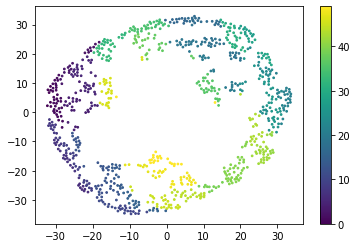

In [20]:
from sklearn.manifold import TSNE
dr=TSNE()
embed_attentions=dr.fit_transform(hidden)

%matplotlib inline
import matplotlib.pyplot as plt

fig,ax=plt.subplots()

scatter=ax.scatter(embed_attentions[:,0], embed_attentions[:,1],
                   c=cluster_labels_train,
                   s=3
                  )

plt.colorbar(scatter)

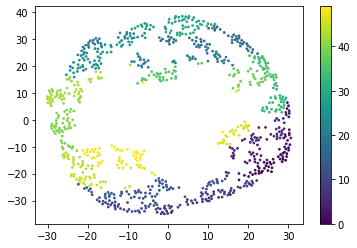

In [21]:
from umap import UMAP
mapper=UMAP()
embed_attentions=dr.fit_transform(hidden)

fig,ax=plt.subplots()

scatter=ax.scatter(embed_attentions[:,0], embed_attentions[:,1],
                   c=cluster_labels_train,
                   s=3
                  )

plt.colorbar(scatter)

## Plot

In [22]:
#Data processed in excel by combining training and validation accuracy columns from individual training_log.csv"
import pandas as pd
SynthDataFolder="SynthData_10dim_nonoise"
df=pd.read_csv(os.path.join("SynthData_10dim_nonoise_results.csv"),
               index_col=False)

In [23]:
df.head()

,Epoch,LLDLwoFW_valacc,DenseModel_valacc,LLDLwoFW_trainacc,DenseModel_trainacc
0,0.0,0.52,0.53,0.513333,0.514444
1,1.0,0.47,0.47,0.517778,0.481111
2,2.0,0.47,0.47,0.541111,0.510000
3,3.0,0.47,0.42,0.524444,0.511111
4,4.0,0.47,0.55,0.482222,0.476667


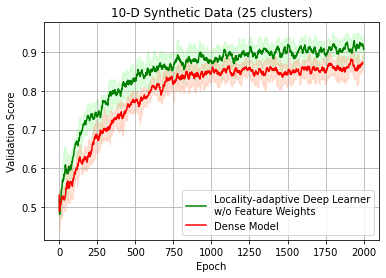

In [39]:
%matplotlib inline

import seaborn as sns
fig,ax=plt.subplots()
df['logEpoch']=np.log10(df['Epoch']+1)
# sns.lineplot('Step', 'AttentionModelwFeatWeights_val', data=att_model_df, ax=ax)
# sns.lineplot('Step', 'AttentionModelwoFeatWeights_val', data=att_model_df, ax=ax)
# sns.lineplot('Step', 'DenseModel_val', data=att_model_df, ax=ax)

def get_mov_ave(y, window_size=3, percentiles=(10,90)):
    assert window_size%2 ==1
    w=int(window_size/2)
    out=[]
    lower=[]
    upper=[]
    l,u=percentiles[0],percentiles[1]
    for i in range(w, len(y)-w):
        out.append(np.average(y[i-w:i+w+1]))
        lower.append(np.percentile(y[i-w:i+w+1],l))
        upper.append(np.percentile(y[i-w:i+w+1],u))

    while w>0:
        w=w-1
        win_size=w*2+1
        out.insert(0, np.average(y[:win_size]))
        lower.insert(0, np.percentile(y[:win_size], l))
        upper.insert(0, np.percentile(y[:win_size], u))
        out.append(np.average(y[len(y)-win_size:]))
        lower.append(np.percentile(y[len(y)-win_size:], l))
        upper.append(np.percentile(y[len(y)-win_size:], u))
    return out, lower, upper

def get_min_max(mov_ave, y):
    assert len(mov_ave)==len(y)
    mins=np.min(np.vstack([mov_ave, y]), axis=0)
    maxs=np.max(np.vstack([mov_ave,y]), axis=0)
    return mins, maxs

colors1=[#"b",
         "g","r"]
colors2=[#"powderblue",
         "palegreen","lightsalmon"]
for idx, i in enumerate([#"LLDLwFW_valacc",
          "LLDLwoFW_valacc", 
          "DenseModel_valacc"
         ]):
    x_plot=df['Epoch']+1
    y_plot=df[i]
    mov_ave, lower, upper=get_mov_ave(y_plot, window_size=15)
    plt.plot(x_plot, mov_ave, c=colors1[idx])
    #mins,maxs=get_min_max(mov_ave, get_mov_ave(y_plot, window_size=3))
    plt.fill_between(x_plot,lower, upper, color=colors2[idx], alpha=0.3)


ax.set_xlabel("Epoch")
ax.set_ylabel("Validation Score")
# ax.set_ylim([0.45, 0.95])
ax.legend([#"Locality-adaptive Deep Learner", 
           "Locality-adaptive Deep Learner\nw/o Feature Weights", 
    "Dense Model"], 
          #bbox_to_anchor=(1,1)
    loc="lower right"
)
ax.set_title("10-D Synthetic Data (25 clusters)")
plt.grid()
# savefile=os.path.join(SynthDataFolder, "SynthData_10dim_LocallyAdaptiveDeepLearner")
# plt.savefig(savefile)

## Random Forest

In [26]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
n_estimators_list=[200,500,1000]
n_repeats=10
random_seeds=range(n_repeats)
min_samples_list=list(range(1,11))
RF_results=[]

for n_estimator in n_estimators_list:
    for min_samples in min_samples_list:
        for i in range(n_repeats):
            np.random.seed(random_seeds[i])
            clf=ExtraTreesClassifier(n_estimators=n_estimator, 
                                     min_samples_leaf=min_samples,
                                     bootstrap=True, 
                                     oob_score=True, 
                                     class_weight="balanced_subsample")
            clf.fit(X_train, y_train)
            train_score=clf.score(X_train, y_train)
            test_score=clf.score(X_test, y_test)
            RF_results.append([n_estimator, min_samples, "train_accuracy", train_score])
            RF_results.append([n_estimator, min_samples, "test_accuracy", test_score])
        
RF_results=pd.DataFrame(RF_results, columns=["n_estimator", "min_samples_leaf", "metric", "score"])

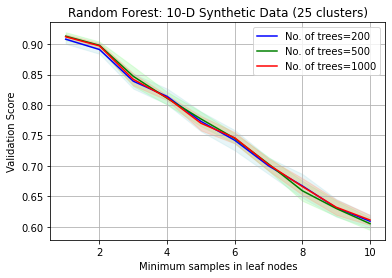

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt

def get_ave_LUbounds(df, x_col_name, percentiles=(10,90)):
    l,u=percentiles[0], percentiles[1]
    x_plot=np.unique(df[x_col_name])
    ave=[]
    lower=[]
    upper=[]
    if percentiles=='std':
        for x in x_plot:
            out=df[df[x_col_name]==x]['score']
            mean, std=np.mean(out), np.std(out)
            ave.append(mean)
            lower.append(mean-std)
            upper.append(mean+std)
        return x_plot, ave, lower, upper
    for x in x_plot:
        out=df[df[x_col_name]==x]['score']
        ave.append(np.mean(out))
        lower.append(np.percentile(out, l))
        upper.append(np.percentile(out, u))
    return x_plot, ave, lower, upper

fig,ax=plt.subplots()

colors1=["b","g","r"]
colors2=["powderblue","palegreen","lightsalmon"]
for idx, n_estimator in enumerate(n_estimators_list):
    out_df=RF_results.query("n_estimator == @n_estimator & metric == 'test_accuracy' ")
    x_plot, ave, lower, upper=get_ave_LUbounds(out_df, x_col_name='min_samples_leaf',
                                               percentiles='std'
                                              )
    ax.plot(x_plot, ave, c=colors1[idx])
    ax.fill_between(x_plot, lower, upper, color=colors2[idx], alpha=0.3)

ax.set_xlabel("Minimum samples in leaf nodes")
ax.set_ylabel("Validation Score")
# ax.set_ylim([0.45, 0.95])
ax.legend(["No. of trees="+str(i) for i in n_estimators_list], 
          loc=("upper right"))
ax.set_title("Random Forest: 10-D Synthetic Data (25 clusters)")

plt.grid()
# savefile=os.path.join(SynthDataFolder, "SynthData_10dim_RF")
# plt.savefig(savefile)

## XGBoost

In [28]:
from xgboost import XGBClassifier
n_estimators_list=[200,500,1000]
n_repeats=3
random_seeds=range(n_repeats)
gamma_list=[0.00001,0.00003,0.0001,0.0003, 0.001, 0.003, 0.01,0.03, 0.1,0.3]
xgb_results=[]
scale_pos_weight= (len(y_train)-np.sum(y_train))/np.sum(y_train) #Ratio of number of negatives to number of positives


for n_estimators in n_estimators_list:
    for gamma in gamma_list:
        for i in range(n_repeats):
            xgb_clf=XGBClassifier(n_estimators=n_estimators,
                                  gamma=gamma,
                                  max_depth=20,
                                  scale_pos_weight=scale_pos_weight,
                                  use_label_encoder=False, 
                                  eval_metric='logloss',
                                  seed=random_seeds[i]
                                 )
            xgb_clf.fit(X_train, y_train)
            train_score=xgb_clf.score(X_train, y_train)
            test_score=xgb_clf.score(X_test, y_test)
            xgb_results.append([n_estimators, gamma, "train_accuracy", train_score])
            xgb_results.append([n_estimators, gamma, "test_accuracy", test_score])
            del xgb_clf
xgb_results=pd.DataFrame(xgb_results, columns=["n_estimator", "gamma", "metric", "score"])

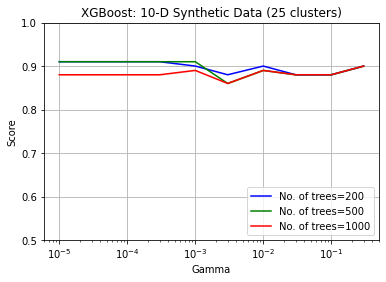

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt

def get_ave_LUbounds(df, x_col_name, percentiles=(10,90)):
    l,u=percentiles[0], percentiles[1]
    x_plot=np.unique(df[x_col_name])
    ave=[]
    lower=[]
    upper=[]
    if percentiles=='std':
        for x in x_plot:
            out=df[df[x_col_name]==x]['score']
            mean, std=np.mean(out), np.std(out)
            ave.append(mean)
            lower.append(mean-std)
            upper.append(mean+std)
        return x_plot, ave, lower, upper
    for x in x_plot:
        out=df[df[x_col_name]==x]['score']
        ave.append(np.mean(out))
        lower.append(np.percentile(out, l))
        upper.append(np.percentile(out, u))
    return x_plot, ave, lower, upper

fig,ax=plt.subplots()

colors1=["b","g","r"]
colors2=["powderblue","palegreen","lightsalmon"]
for idx, n_estimator in enumerate(n_estimators_list):
    out_df=xgb_results.query("n_estimator == @n_estimator & metric == 'test_accuracy' ")
    x_plot, ave, lower, upper=get_ave_LUbounds(out_df, x_col_name='gamma',
                                               percentiles='std'
                                              )
    ax.plot(x_plot, ave, c=colors1[idx])
    ax.fill_between(x_plot, lower, upper, color=colors2[idx], alpha=0.3)

ax.set_xlabel("Gamma")
ax.set_ylabel("Validation Score")
# ax.set_ylim([0.45, 0.95])
ax.legend(["No. of trees="+str(i) for i in n_estimators_list], 
          loc=("lower right"))
ax.set_title("XGBoost: 10-D Synthetic Data (25 clusters)")

ax.set_xscale("log")
ax.set_ylim((0.5,1.))
plt.grid()
# savefile=os.path.join(SynthDataFolder, "SynthData_10dim_RF")
# plt.savefig(savefile)

In [29]:
xgb_results[xgb_results['metric']=="test_accuracy"]

,n_estimator,gamma,metric,score
1,200,0.00001,test_accuracy,0.95
3,200,0.00001,test_accuracy,0.95
5,200,0.00001,test_accuracy,0.95
7,200,0.00003,test_accuracy,0.95
9,200,0.00003,test_accuracy,0.95
...,...,...,...,...
171,1000,0.10000,test_accuracy,0.96
173,1000,0.10000,test_accuracy,0.96
175,1000,0.30000,test_accuracy,0.96
177,1000,0.30000,test_accuracy,0.96


# Trying out Similarity Batching 

In [281]:
#Just create tensorflow function and call it _on_epoch end
    Args:
      variant_tensor: The variant-dtype Tensor associated with the Dataset. This
        Tensor will be a captured input to functions which use the Dataset, and
        is used by saving code to identify the corresponding _VariantTracker.
      resource_creator: A zero-argument function which creates a new
        variant-dtype Tensor. This function will be included in SavedModels and
        run to re-create the Dataset's variant Tensor on restore.

In [ ]:
class UnaryDataset(DatasetV2):
  """Abstract class representing a dataset with one input."""

  def __init__(self, input_dataset, variant_tensor):
    self._input_dataset = input_dataset
    super(UnaryDataset, self).__init__(variant_tensor)

  def _inputs(self):
    return [self._input_dataset]

In [264]:
Sh_ds._variant_tensor_attr?

In [267]:
print(Sh_ds._variant_tensor_attr)

tf.Tensor(<unprintable>, shape=(), dtype=variant)


In [39]:
from tensorflow.python.data.ops.dataset_ops import UnaryDataset
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering

class SimilarityBatchingDataset():
    def __init__(self, 
                 numpy_dataset,
                 numpy_targets,                 
                 attentions,
                 n_batch=8,
                 clusterer_kwargs={"n_clusters":None,
                                   "affinity":"cosine", 
                                   "linkage":"average"
                                  },
                 use_inter_op_parallelism=True,
                 preserve_cardinality=False,
                 use_legacy_function=False,
                 **kwargs
                ):
        self.numpy_dataset=numpy_dataset
        self.numpy_targets=numpy_targets
        self.attentions=attentions
        self.n_batch=n_batch
        self.clusterer_kwargs=clusterer_kwargs
        self._use_inter_op_parallelism=use_inter_op_parallelism
        self._preserve_cardinality=preserve_cardinality
        self._use_legacy_function=use_legacy_function
    
    

    def _partitions(self):
        #Set n_clusters if not initialized
        if self.clusterer_kwargs.get("n_clusters") is None:
            self.clusterer_kwargs["n_clusters"]=20
        
        clusterer=AgglomerativeClustering(**self.clusterer_kwargs)
        clusterer.fit(self.attentions)
        cl_labels=clusterer.labels_
        unique,counts=np.unique(cl_labels, return_counts=True)
        print(f"Fitted {len(unique)} clusters with distribution {np.sort(counts)[::-1]}")
        #Remember to shuffle partitions
        partitions=[np.where(cl_labels==i)[0] for i in np.unique(cl_labels)]
        m=len(partitions)
        rand_order=np.random.choice(range(m), size=m, replace=False)
        partitions=[partitions[i] for i in rand_order]
        
        return partitions

    def get_rearranged_tensor(self):
        arr=np.empty_like(self.numpy_dataset)
        arr_targets=np.empty_like(self.numpy_targets)
        self.partitions=self._partitions()
        ptr=0
        for p in self.partitions:
            arr[ptr:ptr+len(p)]=self.numpy_dataset[p,:]
            arr_targets[ptr:ptr+len(p)]=self.numpy_targets[p,:]
            ptr+=len(p)
        return arr, arr_targets
    
#     def get_similarity_batched_dataset(self):
#         arr=np.empty_like(self.numpy_dataset)
#         self.partitions=self._partitions()
#         ptr=0
#         for p in self.partitions:
#             arr[ptr:ptr+len(p)]=self.numpy_dataset[p,:]
#             ptr+=len(p)
#         ds=tf.data.Dataset.from_tensor_slices(arr)
#         return ds.batch(n_batch)
            
        
        
        

In [40]:
attentions=LSwFW_model.layers[1](train_tensor).numpy()
simbatched=SimilarityBatchingDataset(
    train_data,
    train_targets,
    attentions,
)
rearranged_train_data, rearranged_train_targets=simbatched.get_rearranged_tensor()

Fitted 20 clusters with distribution [232 104  93  80  76  66  59  51  41  36  30  16   5   4   2   1   1   1
   1   1]


In [61]:
LSwFW_model.optimizer.lr.assign(0.001)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=0.001>

In [64]:
np.random.seed(0)

#For a trained LSwFW_model (n_epochs=200; shuffling) 
checkpoint_path=os.path.join("210210_TrainingLocalitySensitivewFW",
                                      "LocalitySensitivewFW_label" )
LSwFW_model.load_weights(checkpoint_path)

simbatched_checkpoint_path=os.path.join("210210_TrainingLocalitySensitivewFW",
                                      "LocalitySensitivewFW_simBatched" )
try:
    os.mkdir(simbatched_checkpoint_path)
except:
    pass

#Set callbacks
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=simbatched_checkpoint_path,
                                                 monitor='val_accuracy',
                                                 mode='max',
                     
                                                 save_best_only=True,
                                                 save_weights_only=True,
                                                 verbose=1)
csv_filename = os.path.join(simbatched_checkpoint_path,
                            "training_log_simBatched_lr0_001.csv"
                            )
csvlogger_callback = tf.keras.callbacks.CSVLogger(filename=csv_filename, append=True)

#Assign learning rate
LSwFW_model.optimizer.lr.assign(0.001)

n_epoch=1000
for i in range(n_epoch):

    #Set training tensors
    attentions=LSwFW_model.layers[1](train_tensor).numpy()
    simbatched=SimilarityBatchingDataset(
        train_tensor,
        train_targets,
        attentions,
    )
    rearranged_train_tensor, rearranged_train_targets=simbatched.get_rearranged_tensor()
    
    #Fit model
    LSwFW_model.fit(rearranged_train_tensor, 
                rearranged_train_targets,
                epochs=1,
                batch_size=n_batch,
                validation_data=(test_tensor, test_targets),
                shuffle=True,
                verbose=2, 
                callbacks=[csvlogger_callback,
                           cp_callback
                          ]
               )

Fitted 20 clusters with distribution [132 120 118 108  89  66  63  51  44  33  24  16  14   8   5   3   2   2
   1   1]
29/29 - 1s - loss: 0.0555 - accuracy: 0.9889 - val_loss: 0.9279 - val_accuracy: 0.8800

Epoch 00001: val_accuracy improved from -inf to 0.88000, saving model to 210210_TrainingLocalitySensitivewFW\LocalitySensitivewFW_simBatched
Fitted 20 clusters with distribution [153 132 126 110  86  66  62  52  34  24  18  15   7   4   3   2   2   2
   1   1]
29/29 - 1s - loss: 0.0450 - accuracy: 0.9911 - val_loss: 0.9368 - val_accuracy: 0.8900

Epoch 00001: val_accuracy improved from 0.88000 to 0.89000, saving model to 210210_TrainingLocalitySensitivewFW\LocalitySensitivewFW_simBatched
Fitted 20 clusters with distribution [153 132 126 111  93  89  61  51  34  12  11   7   4   4   3   3   2   2
   1   1]
29/29 - 1s - loss: 0.0397 - accuracy: 0.9911 - val_loss: 0.9473 - val_accuracy: 0.8900

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution


Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [132 128 112 108  97  89  61  50  34  24  20  14   8   7   5   4   3   2
   1   1]
29/29 - 1s - loss: 0.0257 - accuracy: 0.9989 - val_loss: 1.0872 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [132 128 112 108  97  89  61  50  34  24  20  14   8   7   5   4   3   2
   1   1]
29/29 - 1s - loss: 0.0255 - accuracy: 0.9989 - val_loss: 1.0898 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [132 128 112 108  97  89  61  50  34  24  20  14   8   7   5   4   3   2
   1   1]
29/29 - 1s - loss: 0.0254 - accuracy: 0.9989 - val_loss: 1.0946 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [132 128 112 108 102  89  56  50  34  24  20  14   8   7   5   4   3   2
   1   1]
29/29 - 1s - loss: 0.0252 - accurac

29/29 - 1s - loss: 0.0222 - accuracy: 0.9989 - val_loss: 1.1793 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [145 132 114 109  97  95  59  51  33  20  12   8   8   5   3   3   2   2
   1   1]
29/29 - 1s - loss: 0.0219 - accuracy: 1.0000 - val_loss: 1.1811 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [138 132 114 109 104  95  59  51  33  20  12   8   8   5   3   3   2   2
   1   1]
29/29 - 1s - loss: 0.0220 - accuracy: 0.9989 - val_loss: 1.1832 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [138 132 120 109 104  95  53  51  33  20  12   8   8   5   3   3   2   2
   1   1]
29/29 - 1s - loss: 0.0220 - accuracy: 1.0000 - val_loss: 1.1896 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [141 132 120 104 102  95  53  5


Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [143 130 121 119 103  98  52  51  33  11  10   8   5   4   3   3   2   2
   1   1]
29/29 - 1s - loss: 0.0194 - accuracy: 1.0000 - val_loss: 1.2700 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [143 130 121 119 103  98  52  51  33  11  10   8   5   4   3   3   2   2
   1   1]
29/29 - 1s - loss: 0.0196 - accuracy: 1.0000 - val_loss: 1.2704 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [143 130 121 119 103  98  52  51  33  11  10   8   5   4   3   3   2   2
   1   1]
29/29 - 1s - loss: 0.0192 - accuracy: 1.0000 - val_loss: 1.2729 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [143 130 121 119 103  98  52  51  33  11  10   8   5   4   3   3   2   2
   1   1]
29/29 - 1s - loss: 0.0192 - accurac

29/29 - 1s - loss: 0.0168 - accuracy: 1.0000 - val_loss: 1.3071 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [141 131 120  98  94  81  52  51  33  28  28  11   8   8   6   3   3   2
   1   1]
29/29 - 1s - loss: 0.0167 - accuracy: 1.0000 - val_loss: 1.3108 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [141 131 112 108  98  94  60  51  33  28  11   8   8   6   3   2   2   2
   1   1]
29/29 - 1s - loss: 0.0166 - accuracy: 1.0000 - val_loss: 1.3087 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [141 131 112 108  98  94  60  51  33  28  11   8   8   6   3   2   2   2
   1   1]
29/29 - 1s - loss: 0.0165 - accuracy: 1.0000 - val_loss: 1.3095 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [141 131 112 104  98  94  60  5


Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [141 138 120 107  98  94  52  52  31  21  11   8   8   6   3   3   2   2
   2   1]
29/29 - 1s - loss: 0.0139 - accuracy: 1.0000 - val_loss: 1.3211 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [141 138 116 104  98  97  56  52  31  21  11   8   8   6   3   3   2   2
   2   1]
29/29 - 1s - loss: 0.0138 - accuracy: 1.0000 - val_loss: 1.3202 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [141 138 116 104  98  97  56  52  31  21  11   8   8   6   3   3   2   2
   2   1]
29/29 - 1s - loss: 0.0137 - accuracy: 1.0000 - val_loss: 1.3205 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [141 138 120 107  98  94  52  52  31  21  11   8   8   6   3   3   2   2
   2   1]
29/29 - 1s - loss: 0.0136 - accurac

29/29 - 1s - loss: 0.0110 - accuracy: 1.0000 - val_loss: 1.3121 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [143 129 123 115  99  93  52  38  31  28  14   8   8   6   3   3   2   2
   2   1]
29/29 - 1s - loss: 0.0109 - accuracy: 1.0000 - val_loss: 1.3118 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [143 129 123 115  99  93  52  38  31  28  14   8   8   6   3   3   2   2
   2   1]
29/29 - 1s - loss: 0.0108 - accuracy: 1.0000 - val_loss: 1.3074 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [143 123 115  99  91  70  66  52  38  31  26  14   8   8   6   3   2   2
   2   1]
29/29 - 1s - loss: 0.0107 - accuracy: 1.0000 - val_loss: 1.3037 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [143 123 115  99  91  70  66  5


Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [138 128 111 106  97  95  50  41  36  31  17  15   9   8   5   4   3   2
   2   2]
29/29 - 1s - loss: 0.0688 - accuracy: 0.9822 - val_loss: 1.1153 - val_accuracy: 0.8900

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [135 131 117 105  99  93  57  48  31  23  18  10   9   9   5   3   2   2
   2   1]
29/29 - 1s - loss: 0.0359 - accuracy: 0.9922 - val_loss: 1.0555 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [140 128 107 103  98  93  49  44  31  25  22  11  11  10  10   8   4   3
   2   1]
29/29 - 1s - loss: 0.0145 - accuracy: 0.9989 - val_loss: 1.0303 - val_accuracy: 0.8900

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [140 128 107 105  98  98  49  45  31  25  22  10   9   9   8   5   4   3
   2   2]
29/29 - 1s - loss: 0.0113 - accurac

29/29 - 1s - loss: 0.0085 - accuracy: 1.0000 - val_loss: 1.1137 - val_accuracy: 0.8900

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [140 127 105 105 103  97  51  45  31  25  18  11  10   9   8   7   3   2
   2   1]
29/29 - 1s - loss: 0.0085 - accuracy: 1.0000 - val_loss: 1.1154 - val_accuracy: 0.8800

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [134 131 107 103 102  97  51  45  31  25  18  11  11  10   8   7   3   3
   2   1]
29/29 - 1s - loss: 0.0085 - accuracy: 1.0000 - val_loss: 1.1170 - val_accuracy: 0.8800

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [134 131 107 106 102  97  51  45  31  25  18  11  11  10   7   5   3   3
   2   1]
29/29 - 1s - loss: 0.0085 - accuracy: 1.0000 - val_loss: 1.1191 - val_accuracy: 0.8800

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [134 131 107 106 102  97  51  4


Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [178 113 105 102  97  90  55  51  31  18  15   9   8   8   7   4   3   2
   2   2]
29/29 - 1s - loss: 0.0079 - accuracy: 1.0000 - val_loss: 1.1637 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [178 113 105 102  97  90  55  51  31  18  15   9   8   8   7   4   3   2
   2   2]
29/29 - 1s - loss: 0.0079 - accuracy: 1.0000 - val_loss: 1.1708 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [178 116 106 102  97  86  55  51  31  20  15   9   8   8   6   3   3   2
   2   2]
29/29 - 1s - loss: 0.0079 - accuracy: 1.0000 - val_loss: 1.1740 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [178 116 106 102  97  86  55  51  31  20  15   9   8   8   6   3   3   2
   2   2]
29/29 - 1s - loss: 0.0078 - accurac

29/29 - 1s - loss: 0.0073 - accuracy: 1.0000 - val_loss: 1.2035 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [185 113 110 102  97  95  51  44  31  26   9   9   9   6   3   3   2   2
   2   1]
29/29 - 1s - loss: 0.0072 - accuracy: 1.0000 - val_loss: 1.2055 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [185 113 104 100  97  95  51  44  31  26  10   9   9   9   6   3   3   2
   2   1]
29/29 - 1s - loss: 0.0072 - accuracy: 1.0000 - val_loss: 1.2045 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [185 113 113  99  97  95  51  44  31  26   9   9   9   6   3   3   2   2
   2   1]
29/29 - 1s - loss: 0.0072 - accuracy: 1.0000 - val_loss: 1.2074 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [185 109 108  99  97  95  51  4


Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [178 119 118  98  92  88  51  50  30  23  13  10   9   7   3   3   2   2
   2   2]
29/29 - 1s - loss: 0.0065 - accuracy: 1.0000 - val_loss: 1.2253 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [178 118 118  98  92  88  51  51  30  23  13  10   9   7   3   3   2   2
   2   2]
29/29 - 1s - loss: 0.0065 - accuracy: 1.0000 - val_loss: 1.2265 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [178 118 118  98  92  88  51  51  30  23  13  10   9   7   3   3   2   2
   2   2]
29/29 - 1s - loss: 0.0064 - accuracy: 1.0000 - val_loss: 1.2251 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [178 118 118  98  92  88  51  51  30  23  13  10   9   7   3   3   2   2
   2   2]
29/29 - 1s - loss: 0.0064 - accurac

29/29 - 1s - loss: 0.1093 - accuracy: 0.9867 - val_loss: 1.1305 - val_accuracy: 0.8800

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [177 130 103 101  66  61  60  53  51  30  16  10  10   9   8   6   3   2
   2   2]
29/29 - 1s - loss: 0.0703 - accuracy: 0.9822 - val_loss: 1.4773 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [176 130 103  87  66  65  62  60  32  29  28  23   9   8   8   6   3   3
   1   1]
29/29 - 1s - loss: 0.0929 - accuracy: 0.9733 - val_loss: 1.0366 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [176 132 106 100  66  55  53  51  44  32  22  21  12   8   7   7   3   2
   2   1]
29/29 - 1s - loss: 0.0467 - accuracy: 0.9856 - val_loss: 1.1042 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [177 125 118 106  66  51  51  4

29/29 - 1s - loss: 0.0062 - accuracy: 1.0000 - val_loss: 1.0518 - val_accuracy: 0.8900

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [176 105  98  93  73  54  54  52  51  43  30  24  22   8   8   3   2   2
   1   1]
29/29 - 1s - loss: 0.0062 - accuracy: 1.0000 - val_loss: 1.0528 - val_accuracy: 0.8900

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [176 105  98  93  73  54  54  52  51  43  30  24  22   8   8   3   2   2
   1   1]
29/29 - 1s - loss: 0.0062 - accuracy: 1.0000 - val_loss: 1.0555 - val_accuracy: 0.8900

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [176 105  98  93  73  55  54  52  51  42  30  24  22   8   8   3   2   2
   1   1]
29/29 - 1s - loss: 0.0062 - accuracy: 1.0000 - val_loss: 1.0556 - val_accuracy: 0.8900

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [176 105  98  93  73  55  54  5


Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [176 124 106  98  93  52  51  49  46  30  24  21   8   8   5   3   2   2
   1   1]
29/29 - 1s - loss: 0.0058 - accuracy: 1.0000 - val_loss: 1.1003 - val_accuracy: 0.9000

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [176 124 106  98  93  52  51  49  46  30  24  21   8   8   5   3   2   2
   1   1]
29/29 - 1s - loss: 0.0058 - accuracy: 1.0000 - val_loss: 1.1007 - val_accuracy: 0.9000

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [176 124 106  98  93  52  51  49  46  30  24  21   8   8   5   3   2   2
   1   1]
29/29 - 1s - loss: 0.0058 - accuracy: 1.0000 - val_loss: 1.1035 - val_accuracy: 0.9000

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [176 124 106  98  93  52  51  49  46  30  24  21   8   8   5   3   2   2
   1   1]
29/29 - 1s - loss: 0.0058 - accurac

29/29 - 1s - loss: 0.0055 - accuracy: 1.0000 - val_loss: 1.1330 - val_accuracy: 0.8900

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [177 125 124 104  66  52  50  41  36  33  30  22  11   9   8   4   3   2
   2   1]
29/29 - 1s - loss: 0.0055 - accuracy: 1.0000 - val_loss: 1.1303 - val_accuracy: 0.8900

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [177 125 124 104  66  52  50  41  36  33  30  22  11   9   8   4   3   2
   2   1]
29/29 - 1s - loss: 0.0055 - accuracy: 1.0000 - val_loss: 1.1310 - val_accuracy: 0.8900

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [177 125 124 104  66  52  50  41  36  33  30  22  11   9   8   4   3   2
   2   1]
29/29 - 1s - loss: 0.0055 - accuracy: 1.0000 - val_loss: 1.1328 - val_accuracy: 0.8900

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [177 125 124 104  66  52  50  4


Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [176 148 119 103  51  50  46  45  36  33  30  23  12   8   6   4   4   4
   1   1]
29/29 - 1s - loss: 0.0051 - accuracy: 1.0000 - val_loss: 1.1481 - val_accuracy: 0.8900

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [176 148 119 103  51  50  46  45  36  33  30  23  12   8   6   4   4   4
   1   1]
29/29 - 1s - loss: 0.0051 - accuracy: 1.0000 - val_loss: 1.1492 - val_accuracy: 0.8900

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [176 148 119 103  51  50  46  45  36  33  30  23  12   8   6   4   4   4
   1   1]
29/29 - 1s - loss: 0.0051 - accuracy: 1.0000 - val_loss: 1.1491 - val_accuracy: 0.8900

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [176 148 119 103  51  50  46  45  36  33  30  23  12   8   6   4   4   4
   1   1]
29/29 - 1s - loss: 0.0050 - accurac

29/29 - 1s - loss: 0.0046 - accuracy: 1.0000 - val_loss: 1.1704 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [177 148 121 106  92  50  44  37  32  30  16  12   8   8   6   4   4   2
   2   1]
29/29 - 1s - loss: 0.0046 - accuracy: 1.0000 - val_loss: 1.1702 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [177 148 121 106  92  50  44  37  32  30  16  12   8   8   6   4   4   2
   2   1]
29/29 - 1s - loss: 0.0045 - accuracy: 1.0000 - val_loss: 1.1735 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [177 148 121 106  92  50  44  37  32  30  16  12   8   8   6   4   4   2
   2   1]
29/29 - 1s - loss: 0.0045 - accuracy: 1.0000 - val_loss: 1.1690 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [177 148 118 106  92  51  43  3


Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [176 131 130 111  94  66  51  39  32  31  12   8   5   3   2   2   2   2
   2   1]
29/29 - 1s - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.1187 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [176 131 130 111  94  66  51  39  32  31  12   8   5   3   2   2   2   2
   2   1]
29/29 - 1s - loss: 0.0052 - accuracy: 1.0000 - val_loss: 1.1250 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [176 121 118 115 101  93  51  39  31  15  12   9   5   3   2   2   2   2
   2   1]
29/29 - 1s - loss: 0.0052 - accuracy: 1.0000 - val_loss: 1.1313 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [176 121 118 115 101  93  51  39  31  15  12   9   5   3   2   2   2   2
   2   1]
29/29 - 1s - loss: 0.0052 - accurac

29/29 - 1s - loss: 0.0048 - accuracy: 1.0000 - val_loss: 1.2247 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [177 116 115 113 100  94  51  39  31  15  12   9   9   5   4   3   2   2
   2   1]
29/29 - 1s - loss: 0.0048 - accuracy: 1.0000 - val_loss: 1.2295 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [177 125 113 100  94  66  51  49  39  31  15  12   9   5   4   3   2   2
   2   1]
29/29 - 1s - loss: 0.0047 - accuracy: 1.0000 - val_loss: 1.2315 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [177 125 113 100  94  66  51  49  39  31  15  12   9   5   4   3   2   2
   2   1]
29/29 - 1s - loss: 0.0047 - accuracy: 1.0000 - val_loss: 1.2348 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [177 125 113 100  94  66  51  4


Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [177 116 114 101  88  66  52  49  35  31  15  15  12   6   6   5   5   4
   2   1]
29/29 - 1s - loss: 0.0045 - accuracy: 1.0000 - val_loss: 1.2877 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [177 116 114 101  88  66  52  49  35  31  15  15  12   6   6   5   5   4
   2   1]
29/29 - 1s - loss: 0.0045 - accuracy: 1.0000 - val_loss: 1.2920 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [177 129 116 114  87  66  51  40  32  31  15  12   6   6   5   5   4   2
   1   1]
29/29 - 1s - loss: 0.0045 - accuracy: 1.0000 - val_loss: 1.2923 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [177 129 116 114  87  66  51  40  31  31  15  12   7   6   5   5   4   2
   1   1]
29/29 - 1s - loss: 0.0045 - accurac

29/29 - 1s - loss: 0.0043 - accuracy: 1.0000 - val_loss: 1.3380 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [177 118 115  97  85  66  51  49  40  31  15  15  12   6   6   5   4   4
   2   2]
29/29 - 1s - loss: 0.0043 - accuracy: 1.0000 - val_loss: 1.3397 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [177 116 115  97  87  66  51  49  40  31  15  15  12   6   6   5   4   4
   2   2]
29/29 - 1s - loss: 0.0042 - accuracy: 1.0000 - val_loss: 1.3384 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [177 116 115  97  87  66  51  49  40  31  15  15  12   6   6   5   4   4
   2   2]
29/29 - 1s - loss: 0.0042 - accuracy: 1.0000 - val_loss: 1.3386 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [177 116 115  97  87  66  51  4


Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [175 149 116 111  92  55  51  46  31  16  14  12   8   6   5   4   3   2
   2   2]
29/29 - 1s - loss: 0.0040 - accuracy: 1.0000 - val_loss: 1.3827 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [175 149 116 111  92  55  51  46  31  16  14  12   8   6   5   4   3   2
   2   2]
29/29 - 1s - loss: 0.0040 - accuracy: 1.0000 - val_loss: 1.3863 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [175 149 116 111  92  55  51  46  31  16  14  12   8   6   5   4   3   2
   2   2]
29/29 - 1s - loss: 0.0039 - accuracy: 1.0000 - val_loss: 1.3833 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [175 149 116 111  92  55  51  46  31  16  14  12   8   6   5   4   3   2
   2   2]
29/29 - 1s - loss: 0.0039 - accurac

29/29 - 1s - loss: 0.0036 - accuracy: 1.0000 - val_loss: 1.4299 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [175 149 106 104  90  53  53  51  30  22  17  12  11   6   5   5   4   3
   2   2]
29/29 - 1s - loss: 0.0036 - accuracy: 1.0000 - val_loss: 1.4334 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [175 149 106 104  90  53  53  51  30  22  17  12  11   6   5   5   4   3
   2   2]
29/29 - 1s - loss: 0.0036 - accuracy: 1.0000 - val_loss: 1.4388 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [175 149 106 104  90  53  53  51  30  22  17  12  11   6   5   5   4   3
   2   2]
29/29 - 1s - loss: 0.0036 - accuracy: 1.0000 - val_loss: 1.4256 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [175 149 115 115  90  53  51  4


Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [175 123 103  98  94  90  53  51  30  20  16  13   7   6   6   5   4   3
   2   1]
29/29 - 1s - loss: 0.0032 - accuracy: 1.0000 - val_loss: 1.4624 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [175 149 119 103  92  53  52  46  30  26  20   7   6   6   5   3   3   2
   2   1]
29/29 - 1s - loss: 0.0032 - accuracy: 1.0000 - val_loss: 1.4534 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [175 149 118 103  92  53  53  52  30  26  20   6   6   5   3   3   2   2
   1   1]
29/29 - 1s - loss: 0.0292 - accuracy: 0.9956 - val_loss: 1.2493 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [176 149 119 104 104  53  53  30  30  24  22  12   6   5   4   3   2   2
   1   1]
29/29 - 1s - loss: 0.0799 - accurac

29/29 - 1s - loss: 0.0039 - accuracy: 1.0000 - val_loss: 1.1102 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [177 129 124 119  82  66  54  49  30  16  15  11   8   8   3   2   2   2
   2   1]
29/29 - 1s - loss: 0.0039 - accuracy: 1.0000 - val_loss: 1.1046 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [177 129 124 121  82  66  54  49  30  16  15  10   8   8   3   2   2   2
   1   1]
29/29 - 1s - loss: 0.0039 - accuracy: 1.0000 - val_loss: 1.1118 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [177 129 124 121  82  66  54  49  30  16  15  10   8   8   3   2   2   2
   1   1]
29/29 - 1s - loss: 0.0039 - accuracy: 1.0000 - val_loss: 1.1290 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [177 129 124 112  82  66  54  3


Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [175 126 117 111  96  65  54  35  31  30  15  10  10   9   8   2   2   2
   1   1]
29/29 - 1s - loss: 0.0035 - accuracy: 1.0000 - val_loss: 1.1772 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [175 126 117 111  96  65  54  35  31  30  15  10  10   9   8   2   2   2
   1   1]
29/29 - 1s - loss: 0.0035 - accuracy: 1.0000 - val_loss: 1.1783 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [175 125 117 115  96  65  54  35  31  30  13  11  10   8   6   3   2   2
   1   1]
29/29 - 1s - loss: 0.0035 - accuracy: 1.0000 - val_loss: 1.1778 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [175 125 117 115  96  65  54  35  31  30  13  11  10   8   6   3   2   2
   1   1]
29/29 - 1s - loss: 0.0035 - accurac

29/29 - 1s - loss: 0.0034 - accuracy: 1.0000 - val_loss: 1.2051 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [175 125 114 109  93  65  54  35  31  31  15  14  12   8   6   5   3   2
   2   1]
29/29 - 1s - loss: 0.0034 - accuracy: 1.0000 - val_loss: 1.2117 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [175 125 114 109  93  65  54  35  31  31  15  14  12   8   6   5   3   2
   2   1]
29/29 - 1s - loss: 0.0034 - accuracy: 1.0000 - val_loss: 1.2134 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [175 125 114 109  93  65  54  35  31  31  15  14  12   8   6   5   3   2
   2   1]
29/29 - 1s - loss: 0.0033 - accuracy: 1.0000 - val_loss: 1.2105 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [175 125 114 109  93  65  54  3


Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [175 118 115 110  91  65  54  35  31  31  15  13  12   9   8   8   5   2
   2   1]
29/29 - 1s - loss: 0.0032 - accuracy: 1.0000 - val_loss: 1.2496 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [175 118 115 110  91  65  54  35  31  31  15  13  12   9   8   8   5   2
   2   1]
29/29 - 1s - loss: 0.0032 - accuracy: 1.0000 - val_loss: 1.2474 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [175 118 115 110  91  65  54  35  31  31  15  13  12   9   8   8   5   2
   2   1]
29/29 - 1s - loss: 0.0032 - accuracy: 1.0000 - val_loss: 1.2459 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [175 118 115 110  91  65  54  35  31  31  15  13  12   9   8   8   5   2
   2   1]
29/29 - 1s - loss: 0.0032 - accurac

29/29 - 1s - loss: 0.0030 - accuracy: 1.0000 - val_loss: 1.2774 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [174 126 118 116 104  66  54  49  31  17  11   8   8   5   5   2   2   2
   1   1]
29/29 - 1s - loss: 0.0030 - accuracy: 1.0000 - val_loss: 1.2807 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [174 126 116 111 106  66  54  49  31  17  13  11   8   5   5   2   2   2
   1   1]
29/29 - 1s - loss: 0.0029 - accuracy: 1.0000 - val_loss: 1.2822 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [174 126 116 111 106  66  54  49  31  17  13  11   8   5   5   2   2   2
   1   1]
29/29 - 1s - loss: 0.0029 - accuracy: 1.0000 - val_loss: 1.2805 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [174 126 118 116 104  66  54  4


Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [174 118 116 115 104  65  54  51  30  21  15   8   8   7   5   3   2   2
   1   1]
29/29 - 1s - loss: 0.0027 - accuracy: 1.0000 - val_loss: 1.3011 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [174 118 116 115 104  65  54  51  30  21  15   8   8   7   5   3   2   2
   1   1]
29/29 - 1s - loss: 0.0027 - accuracy: 1.0000 - val_loss: 1.3006 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [174 118 116 115 104  65  54  51  30  21  15   8   8   7   5   3   2   2
   1   1]
29/29 - 1s - loss: 0.0027 - accuracy: 1.0000 - val_loss: 1.2978 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [174 128 118 116 104  65  54  51  30  21   8   8   5   5   4   3   2   2
   1   1]
29/29 - 1s - loss: 0.0027 - accurac

29/29 - 1s - loss: 0.0062 - accuracy: 0.9989 - val_loss: 1.0165 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [174 117 115 109  98  93  53  48  30  23  11   7   6   4   4   3   2   1
   1   1]
29/29 - 1s - loss: 0.0060 - accuracy: 0.9989 - val_loss: 1.0440 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [174 117 115 109  98  93  53  48  30  23  11   7   6   4   4   3   2   1
   1   1]
29/29 - 1s - loss: 0.0058 - accuracy: 0.9989 - val_loss: 1.0184 - val_accuracy: 0.8800

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [174 125 117 115 109  66  53  48  30  23  11   7   6   4   4   3   2   1
   1   1]
29/29 - 1s - loss: 0.0062 - accuracy: 0.9989 - val_loss: 1.0528 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [174 125 118 115 113  66  51  4

In [65]:
np.random.seed(0)

#For a trained LSwFW_model (n_epochs=200; shuffling) 
checkpoint_path=os.path.join("210210_TrainingLocalitySensitivewFW",
                                      "LocalitySensitivewFW_label" )
LSwFW_model.load_weights(checkpoint_path)

simbatched_checkpoint_path=os.path.join("210210_TrainingLocalitySensitivewFW",
                                      "LocalitySensitivewFW_simBatched" )
try:
    os.mkdir(simbatched_checkpoint_path)
except:
    pass

#Set callbacks
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=simbatched_checkpoint_path,
                                                 monitor='val_accuracy',
                                                 mode='max',
                     
                                                 save_best_only=True,
                                                 save_weights_only=True,
                                                 verbose=1)
csv_filename = os.path.join(simbatched_checkpoint_path,
                            "training_log_NosimBatched_lr_0_001.csv"
                            )
csvlogger_callback = tf.keras.callbacks.CSVLogger(filename=csv_filename, append=True)

#Assign learning rate
LSwFW_model.optimizer.lr.assign(0.001)

n_epoch=1000
for i in range(n_epoch):
    #No rearranging of tensors
    #Fit model
    LSwFW_model.fit(train_tensor, 
                train_targets,
                epochs=1,
                batch_size=n_batch,
                validation_data=(test_tensor, test_targets),
                shuffle=True,
                verbose=2, 
                callbacks=[csvlogger_callback,
                           cp_callback
                          ]
               )

29/29 - 1s - loss: 0.0545 - accuracy: 0.9867 - val_loss: 0.9221 - val_accuracy: 0.8900

Epoch 00001: val_accuracy improved from -inf to 0.89000, saving model to 210210_TrainingLocalitySensitivewFW\LocalitySensitivewFW_simBatched
29/29 - 1s - loss: 0.0433 - accuracy: 0.9933 - val_loss: 0.9312 - val_accuracy: 0.8900

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0396 - accuracy: 0.9933 - val_loss: 0.9443 - val_accuracy: 0.8900

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0388 - accuracy: 0.9933 - val_loss: 0.9630 - val_accuracy: 0.8900

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0372 - accuracy: 0.9933 - val_loss: 0.9682 - val_accuracy: 0.8900

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0357 - accuracy: 0.9956 - val_loss: 0.9714 - val_accuracy: 0.8900

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0341 - accuracy: 0.9944 - val_loss:

29/29 - 1s - loss: 0.0227 - accuracy: 0.9989 - val_loss: 1.1696 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0225 - accuracy: 0.9989 - val_loss: 1.1744 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0225 - accuracy: 0.9989 - val_loss: 1.1793 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0224 - accuracy: 1.0000 - val_loss: 1.1820 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0222 - accuracy: 0.9989 - val_loss: 1.1843 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0222 - accuracy: 0.9989 - val_loss: 1.1886 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0220 - accuracy: 0.9989 - val_loss: 1.1906 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000


Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0176 - accuracy: 1.0000 - val_loss: 1.2900 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0176 - accuracy: 1.0000 - val_loss: 1.2909 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0175 - accuracy: 1.0000 - val_loss: 1.2921 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0174 - accuracy: 1.0000 - val_loss: 1.2930 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0173 - accuracy: 1.0000 - val_loss: 1.2966 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0172 - accuracy: 1.0000 - val_loss: 1.2975 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0171 - accuracy: 1.0000 - val_loss: 1.2949 - val_accuracy: 0.8600

29/29 - 1s - loss: 0.0125 - accuracy: 1.0000 - val_loss: 1.3388 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0124 - accuracy: 1.0000 - val_loss: 1.3425 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0123 - accuracy: 1.0000 - val_loss: 1.3408 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0122 - accuracy: 1.0000 - val_loss: 1.3397 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0121 - accuracy: 1.0000 - val_loss: 1.3351 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0120 - accuracy: 1.0000 - val_loss: 1.3390 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0119 - accuracy: 1.0000 - val_loss: 1.3358 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000


Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0096 - accuracy: 1.0000 - val_loss: 1.1468 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0096 - accuracy: 1.0000 - val_loss: 1.1482 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0095 - accuracy: 1.0000 - val_loss: 1.1507 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0095 - accuracy: 1.0000 - val_loss: 1.1531 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0094 - accuracy: 1.0000 - val_loss: 1.1557 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0094 - accuracy: 1.0000 - val_loss: 1.1571 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0094 - accuracy: 1.0000 - val_loss: 1.1595 - val_accuracy: 0.8700

29/29 - 1s - loss: 0.0076 - accuracy: 1.0000 - val_loss: 1.2232 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0076 - accuracy: 1.0000 - val_loss: 1.2215 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0075 - accuracy: 1.0000 - val_loss: 1.2235 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0075 - accuracy: 1.0000 - val_loss: 1.2289 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0075 - accuracy: 1.0000 - val_loss: 1.2283 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0074 - accuracy: 1.0000 - val_loss: 1.2282 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0074 - accuracy: 1.0000 - val_loss: 1.2334 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.89000


Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0068 - accuracy: 1.0000 - val_loss: 1.1874 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0068 - accuracy: 1.0000 - val_loss: 1.1955 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0067 - accuracy: 1.0000 - val_loss: 1.1988 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0067 - accuracy: 1.0000 - val_loss: 1.2026 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0067 - accuracy: 1.0000 - val_loss: 1.2146 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0066 - accuracy: 1.0000 - val_loss: 1.2120 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0066 - accuracy: 1.0000 - val_loss: 1.2180 - val_accuracy: 0.8500

29/29 - 1s - loss: 0.0058 - accuracy: 1.0000 - val_loss: 1.3245 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0058 - accuracy: 1.0000 - val_loss: 1.3295 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0058 - accuracy: 1.0000 - val_loss: 1.3290 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0058 - accuracy: 1.0000 - val_loss: 1.3300 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0058 - accuracy: 1.0000 - val_loss: 1.3291 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0058 - accuracy: 1.0000 - val_loss: 1.3289 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0057 - accuracy: 1.0000 - val_loss: 1.3311 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000


Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0061 - accuracy: 1.0000 - val_loss: 1.0373 - val_accuracy: 0.8800

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0057 - accuracy: 1.0000 - val_loss: 1.0416 - val_accuracy: 0.8800

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0057 - accuracy: 1.0000 - val_loss: 1.0448 - val_accuracy: 0.8800

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0056 - accuracy: 1.0000 - val_loss: 1.0598 - val_accuracy: 0.8900

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0056 - accuracy: 1.0000 - val_loss: 1.0625 - val_accuracy: 0.8900

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0055 - accuracy: 1.0000 - val_loss: 1.0652 - val_accuracy: 0.9000

Epoch 00001: val_accuracy improved from 0.89000 to 0.90000, saving model to 210210_TrainingLocalitySensitivewFW\LocalitySensitivewFW_simBatch


Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0049 - accuracy: 1.0000 - val_loss: 1.1560 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0049 - accuracy: 1.0000 - val_loss: 1.1539 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0049 - accuracy: 1.0000 - val_loss: 1.1542 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0049 - accuracy: 1.0000 - val_loss: 1.1558 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0049 - accuracy: 1.0000 - val_loss: 1.1553 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0049 - accuracy: 1.0000 - val_loss: 1.1555 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0049 - accuracy: 1.0000 - val_loss: 1.1653 - val_accuracy: 0.8700

29/29 - 1s - loss: 0.0043 - accuracy: 1.0000 - val_loss: 1.1666 - val_accuracy: 0.8800

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0042 - accuracy: 1.0000 - val_loss: 1.1685 - val_accuracy: 0.8800

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0042 - accuracy: 1.0000 - val_loss: 1.1705 - val_accuracy: 0.8800

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0042 - accuracy: 1.0000 - val_loss: 1.1594 - val_accuracy: 0.8800

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0042 - accuracy: 1.0000 - val_loss: 1.1681 - val_accuracy: 0.8800

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0042 - accuracy: 1.0000 - val_loss: 1.1676 - val_accuracy: 0.8800

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0042 - accuracy: 1.0000 - val_loss: 1.1679 - val_accuracy: 0.8800

Epoch 00001: val_accuracy did not improve from 0.90000


Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0135 - accuracy: 0.9956 - val_loss: 1.1348 - val_accuracy: 0.8800

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0114 - accuracy: 0.9967 - val_loss: 1.1429 - val_accuracy: 0.8800

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0113 - accuracy: 0.9967 - val_loss: 1.1764 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0222 - accuracy: 0.9944 - val_loss: 1.1309 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0166 - accuracy: 0.9944 - val_loss: 1.1327 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0085 - accuracy: 0.9989 - val_loss: 1.1477 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0078 - accuracy: 0.9989 - val_loss: 1.1641 - val_accuracy: 0.8500

29/29 - 1s - loss: 0.0043 - accuracy: 1.0000 - val_loss: 1.3623 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0043 - accuracy: 1.0000 - val_loss: 1.3624 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0043 - accuracy: 1.0000 - val_loss: 1.3632 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0043 - accuracy: 1.0000 - val_loss: 1.3625 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0043 - accuracy: 1.0000 - val_loss: 1.3638 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0042 - accuracy: 1.0000 - val_loss: 1.3662 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0042 - accuracy: 1.0000 - val_loss: 1.3678 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000


Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0037 - accuracy: 1.0000 - val_loss: 1.4265 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0037 - accuracy: 1.0000 - val_loss: 1.3791 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0037 - accuracy: 1.0000 - val_loss: 1.3644 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0037 - accuracy: 1.0000 - val_loss: 1.3662 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0037 - accuracy: 1.0000 - val_loss: 1.3717 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0037 - accuracy: 1.0000 - val_loss: 1.3710 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0036 - accuracy: 1.0000 - val_loss: 1.3666 - val_accuracy: 0.8700

29/29 - 1s - loss: 0.0197 - accuracy: 0.9944 - val_loss: 1.1070 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0123 - accuracy: 0.9989 - val_loss: 1.1795 - val_accuracy: 0.8300

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0094 - accuracy: 0.9989 - val_loss: 1.1520 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0070 - accuracy: 0.9989 - val_loss: 1.1511 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0051 - accuracy: 0.9989 - val_loss: 1.1380 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0045 - accuracy: 1.0000 - val_loss: 1.1247 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0043 - accuracy: 1.0000 - val_loss: 1.1376 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000


Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0033 - accuracy: 1.0000 - val_loss: 1.2203 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0033 - accuracy: 1.0000 - val_loss: 1.2246 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0033 - accuracy: 1.0000 - val_loss: 1.2250 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0033 - accuracy: 1.0000 - val_loss: 1.2317 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0033 - accuracy: 1.0000 - val_loss: 1.2304 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0033 - accuracy: 1.0000 - val_loss: 1.2296 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0033 - accuracy: 1.0000 - val_loss: 1.2290 - val_accuracy: 0.8600

29/29 - 1s - loss: 0.0030 - accuracy: 1.0000 - val_loss: 1.2863 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0030 - accuracy: 1.0000 - val_loss: 1.2818 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0030 - accuracy: 1.0000 - val_loss: 1.2864 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0030 - accuracy: 1.0000 - val_loss: 1.2864 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0030 - accuracy: 1.0000 - val_loss: 1.2718 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0030 - accuracy: 1.0000 - val_loss: 1.2826 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0030 - accuracy: 1.0000 - val_loss: 1.2895 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000


Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0026 - accuracy: 1.0000 - val_loss: 1.3559 - val_accuracy: 0.8400

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0026 - accuracy: 1.0000 - val_loss: 1.3526 - val_accuracy: 0.8400

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0026 - accuracy: 1.0000 - val_loss: 1.3648 - val_accuracy: 0.8400

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0026 - accuracy: 1.0000 - val_loss: 1.3544 - val_accuracy: 0.8400

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0026 - accuracy: 1.0000 - val_loss: 1.3592 - val_accuracy: 0.8400

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0026 - accuracy: 1.0000 - val_loss: 1.3601 - val_accuracy: 0.8400

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0026 - accuracy: 1.0000 - val_loss: 1.3518 - val_accuracy: 0.8400

In [73]:
#Data processed in excel by combining training and validation accuracy columns from individual training_log.csv"
import pandas as pd
SynthDataFolder="SynthData_10dim_clusternoise_AddBN"
df=pd.read_csv(os.path.join("SynthData10dim_results.csv"),
               index_col=False)

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


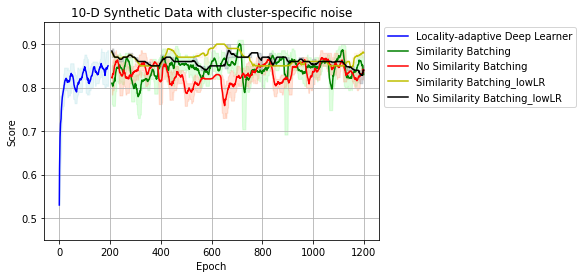

In [74]:
%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
fig,ax=plt.subplots()
df['logEpoch']=np.log10(df['Epoch'])
# sns.lineplot('Step', 'AttentionModelwFeatWeights_val', data=att_model_df, ax=ax)
# sns.lineplot('Step', 'AttentionModelwoFeatWeights_val', data=att_model_df, ax=ax)
# sns.lineplot('Step', 'DenseModel_val', data=att_model_df, ax=ax)

def get_mov_ave(y, window_size=3, percentiles=(10,90)):
    assert window_size%2 ==1
    w=int(window_size/2)
    out=[]
    lower=[]
    upper=[]
    l,u=percentiles[0],percentiles[1]
    for i in range(w, len(y)-w):
        out.append(np.average(y[i-w:i+w+1]))
        lower.append(np.percentile(y[i-w:i+w+1],l))
        upper.append(np.percentile(y[i-w:i+w+1],u))

    while w>0:
        w=w-1
        win_size=w*2+1
        out.insert(0, np.average(y[:win_size]))
        lower.insert(0, np.percentile(y[:win_size], l))
        upper.insert(0, np.percentile(y[:win_size], u))
        out.append(np.average(y[len(y)-win_size:]))
        lower.append(np.percentile(y[len(y)-win_size:], l))
        upper.append(np.percentile(y[len(y)-win_size:], u))
    return out, lower, upper

def get_min_max(mov_ave, y):
    assert len(mov_ave)==len(y)
    mins=np.min(np.vstack([mov_ave, y]), axis=0)
    maxs=np.max(np.vstack([mov_ave,y]), axis=0)
    return mins, maxs

colors1=["b","g","r","y","k"]
colors2=["powderblue","palegreen","lightsalmon","bisque","lightslategray"]
for idx, i in enumerate(["LLDLwFW_valacc",
#           "LLDLwoFW_valacc", 
#           "DenseModel_valacc"
                         "LLDLwFW_simBatched_valacc",
                         "LLDLwFW_NosimBatched_valacc",
                         "LLDLwFW_simBatched_lr_0_001_valacc",
                         "LLDLwFW_NosimBatched_lr_0_001_valacc"
         ]):
    x_plot=df['Epoch']
    y_plot=df[i]
    mov_ave, lower, upper=get_mov_ave(y_plot, window_size=15)
    plt.plot(x_plot, mov_ave, c=colors1[idx])
    #mins,maxs=get_min_max(mov_ave, get_mov_ave(y_plot, window_size=3))
    plt.fill_between(x_plot,lower, upper, color=colors2[idx], alpha=0.3)


ax.set_xlabel("Epoch")
ax.set_ylabel("Score")
ax.set_ylim([0.45, 0.95])
ax.legend(["Locality-adaptive Deep Learner", 
           "Similarity Batching",
           "No Similarity Batching",
           "Similarity Batching_lowLR",
           "No Similarity Batching_lowLR"
          ], 
          bbox_to_anchor=(1,1))
ax.set_title("10-D Synthetic Data with cluster-specific noise")
plt.grid()
# savefile=os.path.join(SynthDataFolder, "SynthData_10dim_LocallyAdaptiveDeepLearner")
# plt.savefig(savefile)

In [ ]:
#Try turning learning rate down to 0.001

In [ ]:
#Try on unbalanced dataset

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


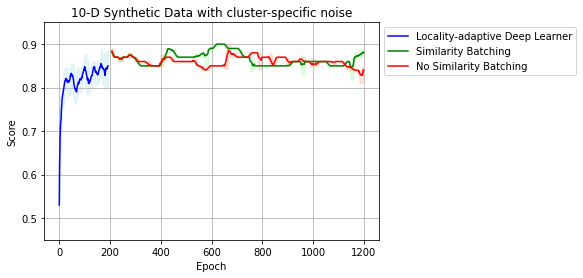

In [78]:
%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
fig,ax=plt.subplots()
df['logEpoch']=np.log10(df['Epoch'])
# sns.lineplot('Step', 'AttentionModelwFeatWeights_val', data=att_model_df, ax=ax)
# sns.lineplot('Step', 'AttentionModelwoFeatWeights_val', data=att_model_df, ax=ax)
# sns.lineplot('Step', 'DenseModel_val', data=att_model_df, ax=ax)

def get_mov_ave(y, window_size=3, percentiles=(10,90)):
    assert window_size%2 ==1
    w=int(window_size/2)
    out=[]
    lower=[]
    upper=[]
    l,u=percentiles[0],percentiles[1]
    for i in range(w, len(y)-w):
        out.append(np.average(y[i-w:i+w+1]))
        lower.append(np.percentile(y[i-w:i+w+1],l))
        upper.append(np.percentile(y[i-w:i+w+1],u))

    while w>0:
        w=w-1
        win_size=w*2+1
        out.insert(0, np.average(y[:win_size]))
        lower.insert(0, np.percentile(y[:win_size], l))
        upper.insert(0, np.percentile(y[:win_size], u))
        out.append(np.average(y[len(y)-win_size:]))
        lower.append(np.percentile(y[len(y)-win_size:], l))
        upper.append(np.percentile(y[len(y)-win_size:], u))
    return out, lower, upper

def get_min_max(mov_ave, y):
    assert len(mov_ave)==len(y)
    mins=np.min(np.vstack([mov_ave, y]), axis=0)
    maxs=np.max(np.vstack([mov_ave,y]), axis=0)
    return mins, maxs

colors1=["b","g","r","y","k"]
colors2=["powderblue","palegreen","lightsalmon","bisque","lightslategray"]
for idx, i in enumerate(["LLDLwFW_valacc",
#           "LLDLwoFW_valacc", 
#           "DenseModel_valacc"
#                          "LLDLwFW_simBatched_valacc",
#                          "LLDLwFW_NosimBatched_valacc",
                         "LLDLwFW_simBatched_lr_0_001_valacc",
                         "LLDLwFW_NosimBatched_lr_0_001_valacc"
         ]):
    x_plot=df['Epoch']
    y_plot=df[i]
    mov_ave, lower, upper=get_mov_ave(y_plot, window_size=15)
    plt.plot(x_plot, mov_ave, c=colors1[idx])
    #mins,maxs=get_min_max(mov_ave, get_mov_ave(y_plot, window_size=3))
    plt.fill_between(x_plot,lower, upper, color=colors2[idx], alpha=0.3)


ax.set_xlabel("Epoch")
ax.set_ylabel("Score")
ax.set_ylim([0.45, 0.95])
ax.legend(["Locality-adaptive Deep Learner", 
#            "Similarity Batching",
#            "No Similarity Batching",
           "Similarity Batching",
           "No Similarity Batching"
          ], 
          bbox_to_anchor=(1,1))
ax.set_title("10-D Synthetic Data with cluster-specific noise")
plt.grid()
# savefile=os.path.join(SynthDataFolder, "SynthData_10dim_LocallyAdaptiveDeepLearner")
# plt.savefig(savefile)